## DataFrame Creation

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import pickle
import gc
import numpy as np
import swifter
import pickle
import seaborn as sns
import pandas as pd
from datetime import datetime
import matplotlib.ticker as mticker
import matplotlib.dates as md
from tqdm import tqdm
from pymongo import MongoClient
from datetime import datetime
import json
from datetime import date
from bson import ObjectId

#from definitions import ROOT_DIR

ImportError: cannot import name 'ROOT_DIR' from 'definitions' (C:\ProgramData\Anaconda3\envs\env_python8\lib\site-packages\definitions\__init__.py)

In [ ]:
#os.chdir(ROOT_DIR)

In [ ]:
#ROOT_DIR

In [1]:
#pip install swifter

In [1]:
#pip install pymongo

In [4]:
#pip install definitions

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for definitions: filename=definitions-0.2.0-py3-none-any.whl size=4556 sha256=21a348dbc44ea71e17a0d014d7d6facd0ec00133bbc057391dc96b77bc4fb39c
  Stored in directory: c:\users\vasil\appdata\local\pip\cache\wheels\fd\f7\85\6697fe1151b7b2bc34d5c619d9489a6131f52a72d8c824442c
Successfully built definitions
Note: you may need to restart the kernel to use updated packages.


## Connecting to MongoDB

In [15]:
with open('credentials.json') as f:
    data = json.load(f)
    username = data['username']
    password = data['password']

# Connection to raisv2 database
client = MongoClient('mongodb://%s:%s@127.0.0.1' % (username, password))
db = client.rais#V3_anonymized

In [16]:
users = db.fitbit.distinct('id')

In [19]:
len(users)

71

## Integrating Fibit Data

Fitbit includes a variety of information, such as physical activity, sleep, and stress patterns, as well data about SpO2, EDA, VO2 max, etc., at different granularities. Here we read each data type and integrate it into our visualization DataFrame with daily granularity.

### Temperature

The night skin temperature of the user during sleep (N=4332).

In [20]:
# Reading temperature data from MongoDB
users_skin_temperature = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
                    db.fitbit.find({ "$and": [
                        { "type": "Computed Temperature"},
                        {"data.type": "SKIN"},
                        {"id": user}
                    ] },
                        {"id": 1, "data.nightly_temperature": 1, "data.sleep_end": 1, "_id": 0}
                    )
                ))

    users_skin_temperature = pd.concat([users_skin_temperature, user_data], axis=0)

# split data column (json format) into two columns
users_skin_temperature["date"] = users_skin_temperature["data"].apply(lambda d: d["sleep_end"])
users_skin_temperature["nightly_temperature"] = users_skin_temperature["data"].apply(lambda d: d["nightly_temperature"])
users_skin_temperature.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_skin_temperature["date"] = pd.to_datetime(pd.to_datetime(users_skin_temperature["date"]).dt.date)



In [21]:
# view
users_skin_temperature.head()


,id,date,nightly_temperature
0,621e2e8e67b776a24055b564,2021-05-25,33.794544
1,621e2e8e67b776a24055b564,2021-05-29,34.610929
2,621e2e8e67b776a24055b564,2021-06-01,34.284452
3,621e2e8e67b776a24055b564,2021-06-05,34.218655
4,621e2e8e67b776a24055b564,2021-06-09,34.056346


In [22]:
len(users_skin_temperature)

3500

In [23]:
# merge with df
df = users_skin_temperature
print("Size after integrating skin temperature: {}".format(df.shape[0]))

Size after integrating skin temperature: 3500


In [24]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'nightly_temperature'], keep=False)].shape[0]))

Duplicates based on ID and Date: 280
Duplicates based on ID and Date and Value: 280


In [25]:
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).first()
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 3500
Size after duplicate elimination: 3359


### Daily Heart Rate Variability Summary

The heart rate variability of the user (N=2891).

In [26]:
users_HRV = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "Daily Heart Rate Variability Summary"},
            {"id": user}
        ]},
            {"id": 1, "data.timestamp": 1, "data.nremhr": 1, "data.rmssd": 1, "_id": 0}
        )
    ))

    users_HRV = pd.concat([users_HRV, user_data], axis=0)

# split data column (json format) into two columns
users_HRV["date"] = users_HRV["data"].apply(lambda d: d["timestamp"])
users_HRV["nremhr"] = users_HRV["data"].apply(lambda d: d["nremhr"])
users_HRV["rmssd"] = users_HRV["data"].apply(lambda d: d["rmssd"])
users_HRV.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_HRV["date"] = pd.to_datetime(pd.to_datetime(users_HRV["date"]).dt.date)

In [27]:
# view
users_HRV.head()

,id,date,nremhr,rmssd
0,621e2e8e67b776a24055b564,2021-05-26,57.481,119.212
1,621e2e8e67b776a24055b564,2021-05-29,57.314,89.941
2,621e2e8e67b776a24055b564,2021-06-01,56.507,117.717
3,621e2e8e67b776a24055b564,2021-06-04,56.439,102.604
4,621e2e8e67b776a24055b564,2021-06-07,53.976,122.089


In [28]:
# merge
df = df.merge(users_HRV, how='outer', on=['id', 'date'])

In [29]:
# view merged
df.head(50)

,id,date,nightly_temperature,nremhr,rmssd
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034
5,621e2e8e67b776a24055b564,2021-05-29,34.610929,57.314,89.941
6,621e2e8e67b776a24055b564,2021-05-30,34.469155,61.900,92.763
7,621e2e8e67b776a24055b564,2021-05-31,34.476865,58.652,109.509
8,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717
9,621e2e8e67b776a24055b564,2021-06-02,34.511263,60.259,111.776


In [30]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'nremhr', 'rmssd'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


### Daily SpO2

Daily oxygen saturation levels of the user (N=1606).

In [31]:
users_spo2 = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "Daily SpO2"},
            {"id": user}
        ]},
            {"id": 1, "data.timestamp": 1, "data.average_value": 1, "_id": 0}
        )
    ))

    users_spo2 = pd.concat([users_spo2, user_data], axis=0)

# split data column (json format) into two columns
users_spo2["date"] = users_spo2["data"].apply(lambda d: d["timestamp"])
users_spo2["spo2"] = users_spo2["data"].apply(lambda d: d["average_value"])
users_spo2.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_spo2["date"] = pd.to_datetime(pd.to_datetime(users_spo2["date"]).dt.date)

In [32]:
# view
users_spo2.head()

,id,date,spo2
0,621e2ef567b776a24099f889,2021-10-19,97.7
0,621e2efa67b776a2409dd1c3,2021-05-30,96.9
1,621e2efa67b776a2409dd1c3,2021-06-16,95.8
2,621e2efa67b776a2409dd1c3,2021-08-19,95.7
3,621e2efa67b776a2409dd1c3,2021-08-31,95.4


In [33]:
# merge
df = df.merge(users_spo2, how='outer', on=['id', 'date'])

In [34]:
df.head(300)

,id,date,nightly_temperature,nremhr,rmssd,spo2
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN
...,...,...,...,...,...,...
295,621e2f1b67b776a240b3d87c,2021-11-16,33.245103,70.701,18.475,NaN
296,621e2f1b67b776a240b3d87c,2021-11-17,33.993565,64.381,19.816,NaN
297,621e2f1b67b776a240b3d87c,2021-11-18,33.136246,68.733,19.553,NaN
298,621e2f1b67b776a240b3d87c,2021-11-19,34.352762,62.164,26.027,NaN


In [35]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
no_dups = df.drop_duplicates()
no_dups[no_dups.duplicated(keep = False, subset=['id','date'])]

,id,date,nightly_temperature,nremhr,rmssd,spo2


In [36]:
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).first()
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 3479
Size after duplicate elimination: 3475


### Respiratory Rate

Data about sleep breathing (N=3517).

In [37]:
users_respiratory_rate = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "Respiratory Rate Summary"},
            {"id": user}
        ]},
            {"id": 1, "data.timestamp": 1, "data.full_sleep_breathing_rate": 1, "_id": 0}
        )
    ))

    users_respiratory_rate = pd.concat([users_respiratory_rate, user_data], axis=0)

# split data column (json format) into two columns
users_respiratory_rate["date"] = users_respiratory_rate["data"].apply(lambda d: d["timestamp"])
users_respiratory_rate["full_sleep_breathing_rate"] = users_respiratory_rate["data"].apply(lambda d: d["full_sleep_breathing_rate"])
users_respiratory_rate.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_respiratory_rate["date"] = pd.to_datetime(pd.to_datetime(users_respiratory_rate["date"]).dt.date)

In [38]:
users_respiratory_rate.head()

,id,date,full_sleep_breathing_rate
0,621e2e8e67b776a24055b564,2021-05-30,15.2
1,621e2e8e67b776a24055b564,2021-06-03,14.0
2,621e2e8e67b776a24055b564,2021-06-18,14.8
3,621e2e8e67b776a24055b564,2021-06-27,15.2
4,621e2e8e67b776a24055b564,2021-07-07,16.2


In [39]:
# merge
df = df.merge(users_respiratory_rate, how='outer', on=['id', 'date'])

In [40]:
df.head(20)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2
5,621e2e8e67b776a24055b564,2021-05-29,34.610929,57.314,89.941,NaN,14.8
6,621e2e8e67b776a24055b564,2021-05-30,34.469155,61.900,92.763,NaN,15.2
7,621e2e8e67b776a24055b564,2021-05-31,34.476865,58.652,109.509,NaN,14.8
8,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717,NaN,14.4
9,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717,NaN,14.4


In [42]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'full_sleep_breathing_rate'], keep=False)].shape[0]))

Duplicates based on ID and Date: 973
Duplicates based on ID and Date and Value: 816


In [43]:
no_dups = df.drop_duplicates()
no_dups[no_dups.duplicated(keep = False, subset=['id','date'])]

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate
138,621e2eaf67b776a2406b14ac,2021-12-17,34.297806,70.880,30.518,NaN,14.4
139,621e2eaf67b776a2406b14ac,2021-12-17,34.297806,70.880,30.518,NaN,14.8
160,621e2eaf67b776a2406b14ac,2022-01-08,33.519558,0.000,32.229,NaN,0.0
161,621e2eaf67b776a2406b14ac,2022-01-08,33.519558,0.000,32.229,NaN,14.2
185,621e2ed667b776a24085d8d1,2021-06-06,34.422184,82.094,0.000,NaN,0.0
...,...,...,...,...,...,...,...
3703,621e367e67b776a24087d75d,2021-06-06,33.199437,59.862,41.776,NaN,12.0
3789,621e367e67b776a24087d75d,2021-12-29,33.749619,76.608,12.992,NaN,12.6
3790,621e367e67b776a24087d75d,2021-12-29,33.749619,76.608,12.992,NaN,13.4
3939,621e375b67b776a240290cdc,2021-06-19,34.495627,65.800,19.570,NaN,17.6


In [44]:
# keep max to avoid 0 breathing rates
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).max()
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 3981
Size after duplicate elimination: 3476


### Stress Score

Fitbit Sense users see a daily Stress Management Score (N=2578) in the Fitbit app ranging from 1 to 100 - where a higher number means you’re showing fewer physical signs of stress. It’s calculated based on three metrics: your Responsiveness (score out of 30), Exertion Balance (score out of 40) and Sleep Patterns (score out of 30).

In [45]:
users_stress = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "Stress Score"},
            {"id": user}
        ]},
            {"id": 1, "data.DATE": 1, "data.STRESS_SCORE": 1, "data.SLEEP_POINTS": 1, "data.MAX_SLEEP_POINTS": 1, "data.EXERTION_POINTS": 1, "data.MAX_EXERTION_POINTS": 1, "data.RESPONSIVENESS_POINTS": 1, "data.MAX_RESPONSIVENESS_POINTS": 1, "_id": 0}
        )
    ))

    users_stress = pd.concat([users_stress, user_data], axis=0)

users_avg_max_sleep_points = np.mean(users_stress["data"].apply(lambda d: d["MAX_SLEEP_POINTS"]))
users_avg_max_exertion_points = np.mean(users_stress["data"].apply(lambda d: d["MAX_EXERTION_POINTS"]))
users_avg_max_responsiveness_points = np.mean(users_stress["data"].apply(lambda d: d["MAX_RESPONSIVENESS_POINTS"]))

# split data column (json format) into two columns
users_stress["date"] = users_stress["data"].apply(lambda d: d["DATE"])
users_stress["stress_score"] = users_stress["data"].apply(lambda d: d["STRESS_SCORE"])
users_stress["sleep_points_percentage"] = users_stress["data"].apply(lambda d: d["SLEEP_POINTS"]/d["MAX_SLEEP_POINTS"] if d["MAX_SLEEP_POINTS"] != 0 else d["SLEEP_POINTS"]/users_avg_max_sleep_points)
users_stress["exertion_points_percentage"] = users_stress["data"].apply(lambda d: d["EXERTION_POINTS"]/d["MAX_EXERTION_POINTS"] if d["MAX_EXERTION_POINTS"] != 0 else d["EXERTION_POINTS"]/users_avg_max_exertion_points)
users_stress["responsiveness_points_percentage"] = users_stress["data"].apply(lambda d: d["RESPONSIVENESS_POINTS"]/d["MAX_RESPONSIVENESS_POINTS"] if d["MAX_RESPONSIVENESS_POINTS"] != 0 else d["RESPONSIVENESS_POINTS"]/users_avg_max_responsiveness_points)
users_stress.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_stress["date"] = pd.to_datetime(pd.to_datetime(users_stress["date"]).dt.date)

In [46]:
users_stress.head()

,id,date,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage
0,621e2e8e67b776a24055b564,2021-05-26,84,0.966667,0.725,0.866667
1,621e2e8e67b776a24055b564,2021-06-07,79,0.900000,0.650,0.866667
2,621e2e8e67b776a24055b564,2021-06-25,76,0.800000,0.725,0.766667
3,621e2e8e67b776a24055b564,2021-07-08,76,0.833333,0.675,0.800000
4,621e2e8e67b776a24055b564,2021-07-20,69,0.633333,0.725,0.700000


In [47]:
# merge
#df = df.merge(users_stress, how='outer', on=['id', 'date'])

#df.head()

In [50]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
#print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
#print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'stress_score'], keep=False)].shape[0]))

In [51]:
df.head()

nightly_temperature  nremhr    rmssd  \
id                       date                                               
621e2e8e67b776a24055b564 2021-05-24            34.137687  57.432   89.603   
                         2021-05-25            33.794544  57.681   94.303   
                         2021-05-26            34.611011  57.481  119.212   
                         2021-05-27            34.408304  57.493  111.709   
                         2021-05-28            34.178922  56.750  103.034   

                                     spo2  full_sleep_breathing_rate  
id                       date                                         
621e2e8e67b776a24055b564 2021-05-24   NaN                       14.8  
                         2021-05-25   NaN                       15.8  
                         2021-05-26   NaN                       14.6  
                         2021-05-27   NaN                       14.8  
                         2021-05-28   NaN                       15.2

### Wrist Temperature

Data about the skin temperature of the user during the day (N=5,217,923). The value refers to the difference between the measured value and the user’s 30-day baseline (unknown where the baseline is stored or how it is calculated). The data are stored at a 3-minute granularity.

In [52]:
if os.path.exists('users_temperature.pkl'):
    print("Reading from pickle...")
    users_wrist_temperature = pd.read_pickle("users_temperature.pkl")
else:
    users_wrist_temperature = pd.DataFrame(columns=["id", "data"])
    for user in users:
        user_data = pd.DataFrame(list(
            db.fitbit.find({"$and": [
                {"type": "Wrist Temperature"},
                {"id": user}
            ]},
                {"id": 1, "data.recorded_time": 1, "data.temperature": 1, "_id": 0}
            )
        ))

        users_wrist_temperature = pd.concat([users_wrist_temperature, user_data], axis=0)

    # split data column (json format) into two columns
    users_wrist_temperature["date"] = users_wrist_temperature["data"].swifter.apply(lambda d: d["recorded_time"])
    users_wrist_temperature["daily_temperature_variation"] = users_wrist_temperature["data"].swifter.apply(lambda d: d["temperature"])
    users_wrist_temperature.drop(["data"], inplace=True, axis=1)

    # convert timestamp date object and then to datetime64[ns]
    users_wrist_temperature["date"] = pd.to_datetime(pd.to_datetime(users_wrist_temperature["date"]).dt.date, infer_datetime_format=True)



C:\ProgramData\Anaconda3\envs\env_python8\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/4372238 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4372238 [00:00<?, ?it/s]

In [53]:
users_wrist_temperature.head()

,id,date,daily_temperature_variation
0,621e2e8e67b776a24055b564,2021-05-24,-1.179795
1,621e2e8e67b776a24055b564,2021-05-24,-1.019795
2,621e2e8e67b776a24055b564,2021-05-24,-1.089795
3,621e2e8e67b776a24055b564,2021-05-24,-1.269795
4,621e2e8e67b776a24055b564,2021-05-24,-1.314795


In [55]:
users_wrist_temperature.to_pickle("users_temperature.pkl")

In [56]:
# group by date and then take the average
users_wrist_temperature = users_wrist_temperature.groupby(['id', 'date']).mean()
users_wrist_temperature.reset_index(drop=False, inplace=True)

In [57]:
users_wrist_temperature.head()

,id,date,daily_temperature_variation
0,621e2e8e67b776a24055b564,2021-05-24,-1.788325
1,621e2e8e67b776a24055b564,2021-05-25,-2.462709
2,621e2e8e67b776a24055b564,2021-05-26,-2.385801
3,621e2e8e67b776a24055b564,2021-05-27,-2.124199
4,621e2e8e67b776a24055b564,2021-05-28,-2.396873


In [58]:
# merge
df = df.merge(users_wrist_temperature, how='outer', on=['id', 'date'])

In [59]:
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,-1.788325
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,-2.462709
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,-2.385801
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,-2.124199
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,-2.396873


In [60]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'daily_temperature_variation'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


### Badge

Users get badges some days depending on their activity (N=1067). There is a variety of badges and users get them at random times, so we expect a lot of null values. To minimize the feature space we can use only the badge type, i.e., "DAILY_FLOORS", "DAILY_STEPS", "GOAL_BASED_WEIGHT_LOSS", "GOAL_BASED_WEIGHT_LOSS_ACHIEVEMENT", "LIFETIME_DISTANCE", "LIFETIME_FLOORS", "LIFETIME_WEIGHT_GOAL_SETUP".

In [61]:
users_badges = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "badge"},
            {"id": user}
        ]},
            {"id": 1, "data.dateTime": 1, "data.badgeType": 1, "_id": 0}
        )
    ))

    users_badges = pd.concat([users_badges, user_data], axis=0)

# split data column (json format) into two columns
users_badges["date"] = users_badges["data"].apply(lambda d: d["dateTime"])
users_badges["badgeType"] = users_badges["data"].apply(lambda d: d["badgeType"])
users_badges.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_badges["date"] = pd.to_datetime(pd.to_datetime(users_badges["date"]).dt.date)

In [62]:
users_badges.head()

,id,date,badgeType
0,621e2e8e67b776a24055b564,2021-05-29,DAILY_FLOORS
1,621e2e8e67b776a24055b564,2021-05-29,DAILY_FLOORS
2,621e2e8e67b776a24055b564,2021-07-31,DAILY_STEPS
3,621e2e8e67b776a24055b564,2021-05-27,LIFETIME_DISTANCE
4,621e2e8e67b776a24055b564,2021-05-29,DAILY_FLOORS


In [63]:
# group by ID and date to have only unique dates per participant
users_badges = users_badges.groupby(['id', 'date']).badgeType.apply(list).reset_index(drop=False)
users_badges.badgeType = users_badges.badgeType.swifter.apply(lambda l: list(set(l)) if isinstance(l, list) else l)
users_badges.badgeType = users_badges.badgeType.swifter.apply(lambda l: np.NaN if l == [np.nan] else l)
users_badges.badgeType.value_counts()

Pandas Apply:   0%|          | 0/515 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/515 [00:00<?, ?it/s]

[LIFETIME_DISTANCE]                                                128
[DAILY_STEPS]                                                      111
[DAILY_FLOORS, DAILY_STEPS]                                         83
[LIFETIME_FLOORS]                                                   77
[DAILY_FLOORS]                                                      75
[LIFETIME_FLOORS, LIFETIME_DISTANCE]                                14
[LIFETIME_FLOORS, DAILY_STEPS]                                       7
[DAILY_FLOORS, LIFETIME_DISTANCE, DAILY_STEPS]                       4
[LIFETIME_WEIGHT_GOAL_SETUP]                                         4
[LIFETIME_FLOORS, DAILY_FLOORS, DAILY_STEPS]                         3
[LIFETIME_FLOORS, DAILY_FLOORS]                                      3
[LIFETIME_DISTANCE, DAILY_STEPS]                                     2
[LIFETIME_FLOORS, DAILY_FLOORS, LIFETIME_DISTANCE, DAILY_STEPS]      1
[DAILY_FLOORS, LIFETIME_DISTANCE]                                    1
[LIFET

In [64]:
# merge
df = df.merge(users_badges, how='outer', on=['id', 'date'])

In [65]:
df.head(100)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,-1.788325,NaN
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,-2.462709,NaN
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,-2.385801,NaN
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,-2.124199,[LIFETIME_DISTANCE]
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,-2.396873,NaN
...,...,...,...,...,...,...,...,...,...
95,621e2eaf67b776a2406b14ac,2021-12-04,34.331876,69.977,22.094,NaN,15.4,-2.511070,NaN
96,621e2eaf67b776a2406b14ac,2021-12-05,33.945212,68.435,27.326,NaN,14.4,-1.935452,NaN
97,621e2eaf67b776a2406b14ac,2021-12-06,34.361535,66.607,27.520,NaN,15.0,-2.095694,NaN
98,621e2eaf67b776a2406b14ac,2021-12-07,34.191339,64.756,29.701,NaN,13.8,-2.029106,NaN


In [66]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.astype(str).duplicated(subset=['id','date', 'badgeType'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


### Calories

Burnt calories for the user at 3-min granularity (N=16,091,073).

In [67]:
if os.path.exists('users_calories.pkl'):
    print("Reading from pickle...")
    f = open("users_calories.pkl", "rb")
    # disable garbage collector
    gc.disable()
    # read pickle
    users_calories = pickle.load(f)
    # enable garbage collector again
    gc.enable()
    f.close()
else:
    users_calories = pd.DataFrame(columns=["id", "data"])
    for user in tqdm(users):
        user_data = pd.DataFrame(list(
            db.fitbit.find({"$and": [
                {"type": "calories"},
                {"id": user}
            ]},
                {"id": 1, "data.dateTime": 1, "data.value": 1, "_id": 0}
            )
        ))

        users_calories = pd.concat([users_calories, user_data], axis=0)

    print("Column Split...")
    # split data column (json format) into two columns
    users_calories.reset_index(drop=True, inplace=True)
    users_calories["date"] = users_calories["data"].swifter.apply(lambda d: d["dateTime"])
    users_calories["calories"] = users_calories["data"].swifter.apply(lambda d: d["value"])
    users_calories.drop(["data"], inplace=True, axis=1)
    print("Column Split Completed")
    print("Date Conversion...")
    # convert timestamp date object and then to datetime64[ns]
    users_calories["date"] = pd.to_datetime(users_calories["date"], format="%m/%d/%y %H:%M:%S").dt.date
    users_calories["date"] = pd.to_datetime(users_calories["date"], format="%Y/%m/%d")
    print("Date Conversion Completed")
    users_calories.to_pickle('users_calories.pkl')

100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [01:39<00:00,  1.41s/it]


Column Split...


Pandas Apply:   0%|          | 0/9675782 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/9675782 [00:00<?, ?it/s]

Column Split Completed
Date Conversion...
Date Conversion Completed


In [68]:
users_calories.head()

,id,date,calories
0,621e2e8e67b776a24055b564,2021-05-24,1.09
1,621e2e8e67b776a24055b564,2021-05-24,1.31
2,621e2e8e67b776a24055b564,2021-05-24,1.31
3,621e2e8e67b776a24055b564,2021-05-24,1.09
4,621e2e8e67b776a24055b564,2021-05-24,1.42


In [69]:
users_calories.dtypes

id                  object
date        datetime64[ns]
calories            object
dtype: object

In [70]:
# group by date and then take the average
users_calories.calories = users_calories.calories.astype(float)
users_calories = users_calories.groupby(['id', 'date']).sum()
users_calories.reset_index(drop=False, inplace=True)

In [71]:
users_calories.head()

,id,date,calories
0,621e2e8e67b776a24055b564,2021-05-24,2351.59
1,621e2e8e67b776a24055b564,2021-05-25,2332.08
2,621e2e8e67b776a24055b564,2021-05-26,2262.30
3,621e2e8e67b776a24055b564,2021-05-27,2325.10
4,621e2e8e67b776a24055b564,2021-05-28,2586.76


In [72]:
# merge
df = df.merge(users_calories, how='outer', on=['id', 'date'])

In [73]:
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,-1.788325,NaN,2351.59
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,-2.462709,NaN,2332.08
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,-2.385801,NaN,2262.30
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,-2.124199,[LIFETIME_DISTANCE],2325.10
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,-2.396873,NaN,2586.76


In [74]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'calories'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


### VO2 Max

VO2 Max is a measurement of how well your body uses oxygen when you’re working out at your hardest. It is widely accepted as the gold standard for grading cardiovascular fitness: the higher your VO2 Max, the more fit you are (source). This metric can also indicate performance potential for endurance-based activities including running, biking, and swimming (source).

VO2 Max is traditionally measured in a lab where you run on a treadmill or ride a stationary bike until exhaustion with a mask strapped to your nose and mouth to gauge the amount of air you inhale and exhale. While this method provides the most accurate measure of VO2 Max, your Fitbit device can estimate this value for you with less effort and discomfort.

Fitbit estimates your VO2 Max and refers to it as your cardio fitness score at a 2-day granularity (N=6364).

In [75]:
users_vo2max = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "demographic_vo2_max"},
            {"id": user}
        ]},
            {"id": 1, "data.dateTime": 1, "data.value.filteredDemographicVO2Max": 1, "_id": 0}
        )
    ))

    users_vo2max = pd.concat([users_vo2max, user_data], axis=0)

# split data column (json format) into two columns
users_vo2max["date"] = users_vo2max["data"].apply(lambda d: d["dateTime"])
users_vo2max["filteredDemographicVO2Max"] = users_vo2max["data"].apply(lambda d: d["value"].get("filteredDemographicVO2Max"))
users_vo2max.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_vo2max["date"] = pd.to_datetime(pd.to_datetime(users_vo2max["date"]).dt.date)

In [76]:
users_vo2max.head()

,id,date,filteredDemographicVO2Max
0,621e2e8e67b776a24055b564,2021-05-25,62.67912
1,621e2e8e67b776a24055b564,2021-05-28,62.41166
2,621e2e8e67b776a24055b564,2021-05-31,62.10474
3,621e2e8e67b776a24055b564,2021-06-03,62.04246
4,621e2e8e67b776a24055b564,2021-06-06,62.13734


In [77]:
# merge
df = df.merge(users_vo2max, how='outer', on=['id', 'date'])

In [78]:
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,-1.788325,NaN,2351.59,62.79210
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,-2.462709,NaN,2332.08,62.67912
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,-2.385801,NaN,2262.30,62.57307
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,-2.124199,[LIFETIME_DISTANCE],2325.10,62.47493
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,-2.396873,NaN,2586.76,62.41166


In [80]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'filteredDemographicVO2Max'], keep=False)].shape[0]))

Duplicates based on ID and Date: 122
Duplicates based on ID and Date and Value: 122


In [81]:
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).first()
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 6732
Size after duplicate elimination: 6671


### Distance

Distance walked by the user at 2-min granularity.

In [82]:
if os.path.exists('users_distance.pkl'):
    print("Reading from pickle...")
    f = open("users_distance.pkl", "rb")
    # disable garbage collector
    gc.disable()
    # read pickle
    users_distance = pickle.load(f)
    # enable garbage collector again
    gc.enable()
    f.close()
else:
    users_distance = pd.DataFrame(columns=["id", "data"])
    for user in tqdm(users):
        user_data = pd.DataFrame(list(
            db.fitbit.find({"$and": [
                {"type": "distance"},
                {"id": user}
            ]},
                {"id": 1, "data.dateTime": 1, "data.value": 1, "_id": 0}
            )
        ))

        users_distance = pd.concat([users_distance, user_data], axis=0)

    print("Column Split...")
    # split data column (json format) into two columns
    users_distance.reset_index(drop=True, inplace=True)
    users_distance["date"] = users_distance["data"].swifter.apply(lambda d: d["dateTime"])
    users_distance["distance"] = users_distance["data"].swifter.apply(lambda d: d["value"])
    users_distance.drop(["data"], inplace=True, axis=1)
    print("Column Split Completed")
    print("Date Conversion...")
    # convert timestamp date object and then to datetime64[ns]
    users_distance["date"] = pd.to_datetime(users_distance["date"], infer_datetime_format=True).dt.date
    users_distance["date"] = pd.to_datetime(users_distance["date"], infer_datetime_format=True)
    print("Date Conversion Completed")
    users_distance.to_pickle('users_distance.pkl')

100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:30<00:00,  2.32it/s]


Column Split...


Pandas Apply:   0%|          | 0/3010529 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3010529 [00:00<?, ?it/s]

Column Split Completed
Date Conversion...
Date Conversion Completed


In [83]:
users_distance.head()

,id,date,distance
0,621e2e8e67b776a24055b564,2021-05-24,880
1,621e2e8e67b776a24055b564,2021-05-24,0
2,621e2e8e67b776a24055b564,2021-05-24,660
3,621e2e8e67b776a24055b564,2021-05-24,0
4,621e2e8e67b776a24055b564,2021-05-24,0


In [84]:
# group by date and then take the average
users_distance.distance = users_distance.distance.astype(float)
users_distance = users_distance.groupby(['id', 'date']).sum()
users_distance.reset_index(drop=False, inplace=True)
users_distance.distance = users_distance.distance / 100  # converts cm to m

<AxesSubplot:>

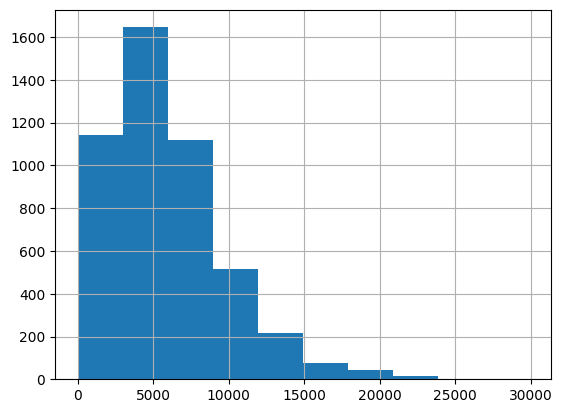

In [85]:
users_distance.distance.hist()

In [86]:
# merge
df = df.merge(users_distance, how='outer', on=['id', 'date'])

In [87]:
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,distance
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,-1.788325,None,2351.59,62.79210,6517.5
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,-2.462709,None,2332.08,62.67912,7178.6
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,-2.385801,None,2262.30,62.57307,6090.9
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,-2.124199,[LIFETIME_DISTANCE],2325.10,62.47493,6653.1
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,-2.396873,None,2586.76,62.41166,9557.9


In [88]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'distance'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


### Exercise

The types of exercise the user has performed (N=5416). The names can be in multiple languages, hence we will use the exercise type code.

In [89]:
users_exercise = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "exercise"},
            {"id": user}
        ]},
            {"id": 1, "data.originalStartTime": 1, "data.activityTypeId": 1, "_id": 0}
        )
    ))

    users_exercise = pd.concat([users_exercise, user_data], axis=0)

# split data column (json format) into two columns
users_exercise["date"] = users_exercise["data"].apply(lambda d: d["originalStartTime"])
users_exercise["activityType"] = users_exercise["data"].apply(lambda d: d["activityTypeId"])
users_exercise.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_exercise["date"] = pd.to_datetime(pd.to_datetime(users_exercise["date"], infer_datetime_format=True).dt.date)

In [90]:
users_exercise.head()

,id,date,activityType
0,621e2e8e67b776a24055b564,2021-05-24,90013
1,621e2e8e67b776a24055b564,2021-05-26,90013
2,621e2e8e67b776a24055b564,2021-05-28,90013
3,621e2e8e67b776a24055b564,2021-05-29,90013
4,621e2e8e67b776a24055b564,2021-06-01,90013


In [91]:
users_exercise.dtypes

id                      object
date            datetime64[ns]
activityType             int64
dtype: object

In [92]:
# Get distinct activity types
activity_types = pd.DataFrame(list(
        db.fitbit.find(
            {"type": "exercise"},
            {"id": 1, "data.activityTypeId": 1, "data.activityName": 1, "_id": 0}
        )
    ))
activity_types["activityTypeId"] = activity_types.data.apply(lambda d: d["activityTypeId"])
activity_types["activityName"] = activity_types.data.apply(lambda d: d["activityName"])
activity_types.drop(["data", "id"], inplace=True, axis=1)
activity_types = activity_types.drop_duplicates().reset_index(drop=True)
print(activity_types.head(50))
ACTIVITIES = {
    90013: "Walk",
    15000: "Sport",
    3001: "Aerobic Workout",
    52000: "Yoga/Pilates",
    90024: "Swim",
    90001: "Bike",
    20047: "Elliptical",
    2131: "Weights",
    55001: "Spinning",
    1071: "Bike",
    90009: "Run",
    20049: "Treadmill",
    53000: "Yoga/Pilates",
    55002: "Martial Arts",
    2040: "Circuit Training",
    2065: "Stairclimber",
    3000: "Workout",
    90012: "Hike",
    12339646: "Run",
    12350445: "Walk",
    23418750: "Swim",
    55003: "Bootcamp",
    15430: "Martial Arts",
    20057: "Interval Workout",
    15675: "Tennis",
    61980497: "Workout"
}

    activityTypeId      activityName
0            90013              Walk
1            15000             Sport
2             3001   Aerobic Workout
3            90024              Swim
4            52000      Yoga/Pilates
5            90001              Bike
6            55001          Spinning
7             2131           Weights
8            20047        Elliptical
9            90009               Run
10            1071              Bike
11           20049         Treadmill
12           53000      Yoga/Pilates
13           55002      Martial Arts
14            2040  Circuit Training
15            3000           Workout
16           90012              Hike
17           55003          Bootcamp
18           15430      Martial Arts
19           15675            Tennis
20           20057  Interval Workout


In [93]:
users_exercise["activityType"] = users_exercise["activityType"].apply(lambda a: ACTIVITIES.get(a))
users_exercise.head()

,id,date,activityType
0,621e2e8e67b776a24055b564,2021-05-24,Walk
1,621e2e8e67b776a24055b564,2021-05-26,Walk
2,621e2e8e67b776a24055b564,2021-05-28,Walk
3,621e2e8e67b776a24055b564,2021-05-29,Walk
4,621e2e8e67b776a24055b564,2021-06-01,Walk


In [94]:
users_exercise = users_exercise.groupby(['id', 'date']).activityType.apply(list).reset_index(drop=False)

In [95]:
users_exercise.activityType.value_counts()

[Walk]                                                                     717
[Walk, Walk]                                                               449
[Walk, Walk, Walk]                                                         132
[Workout]                                                                   83
[Run]                                                                       64
                                                                          ... 
[Run, Aerobic Workout, Aerobic Workout, Walk]                                1
[Walk, Aerobic Workout, Walk, Sport, Walk, Aerobic Workout, Run, Sport]      1
[Run, Sport, Sport, Walk]                                                    1
[Aerobic Workout, Walk, Sport, Aerobic Workout, Aerobic Workout]             1
[Walk, Walk, Swim]                                                           1
Name: activityType, Length: 227, dtype: int64

In [96]:
users_exercise.activityType = users_exercise.activityType.swifter.apply(lambda l: list(set(l)) if isinstance(l, list) else l)

Pandas Apply:   0%|          | 0/2213 [00:00<?, ?it/s]

In [97]:
users_exercise.activityType.value_counts()

[Walk]                                 1374
[Workout]                                90
[Bike]                                   85
[Run]                                    69
[Bike, Walk]                             48
                                       ... 
[Workout, Yoga/Pilates]                   1
[Bike, Walk, Workout]                     1
[Walk, Sport, Aerobic Workout, Run]       1
[Workout, Walk, Hike]                     1
[Interval Workout, Workout]               1
Name: activityType, Length: 80, dtype: int64

In [98]:
# merge
df = df.merge(users_exercise, how='outer', on=['id', 'date'])

In [99]:
df.activityType.value_counts()

[Walk]                                 1374
[Workout]                                90
[Bike]                                   85
[Run]                                    69
[Bike, Walk]                             48
                                       ... 
[Bike, Walk, Workout]                     1
[Treadmill, Workout]                      1
[Workout, Walk, Hike]                     1
[Walk, Sport, Aerobic Workout, Run]       1
[Interval Workout]                        1
Name: activityType, Length: 80, dtype: int64

In [100]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.astype(str).duplicated(subset=['id','date', 'activityType'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


In [101]:
df.to_pickle("temp_df_1.pkl")

### Heart Rate

User’s BPM at 10-sec granularity.

In [103]:
if os.path.exists('temp_df_1.pkl'):
    print("Reading DataFrame from pickle...")
    f = open("temp_df_1.pkl", "rb")
    # disable garbage collector
    gc.disable()
    # read pickle
    df = pickle.load(f)
    # enable garbage collector again
    gc.enable()
    f.close()
    print("Reading completed.")

Reading DataFrame from pickle...
Reading completed.


In [104]:
if os.path.exists('users_hr_daily.pkl'):
    print("Reading daily data from pickle...")
    f = open("users_hr_daily.pkl", "rb")
    # disable garbage collector
    gc.disable()
    # read pickle
    users_hr = pickle.load(f)
    # enable garbage collector again
    gc.enable()
    f.close()
    print("Reading completed.")
elif os.path.exists('users_hr.pkl'):
    print("Reading raw data from pickle...")
    f = open("users_hr.pkl", "rb")
    # disable garbage collector
    gc.disable()
    # read pickle
    users_hr = pickle.load(f)
    # enable garbage collector again
    gc.enable()
    f.close()
    print("Reading completed.")

    users_hr.bpm = users_hr.bpm.astype(float)
    users_hr = users_hr.groupby(['id', 'date']).mean()
    users_hr.reset_index(drop=False, inplace=True)
else:
    warnings.warn("\nTo read and aggregate heart rate data from MongoDB you need to ensure index existence for both query (type, id) and projection (data.dateTime, data.value.bpm) fields (compound index of four fields)...\n")
    rows = 0
    users_hr = pd.DataFrame(columns=["id", "date", "bpm"])
    for user in tqdm(users):
        user_data = pd.DataFrame(list(
            db.fitbit.find({"$and": [
                {"id": user},
                {"type": "heart_rate"}
            ]},
                {"id": 1, "data.dateTime": 1, "data.value.bpm": 1, "_id": 0}
            )
        ))

        # split data column (json format) into two columns
        # user_data.reset_index(drop=True, inplace=True)
        user_data["date"] = user_data["data"].swifter.apply(lambda d: d["dateTime"])
        user_data["bpm"] = user_data["data"].swifter.apply(lambda d: d["value"].get("bpm"))
        user_data.drop(["data"], inplace=True, axis=1)
        # convert timestamp date object and then to datetime64[ns]
        user_data["date"] = pd.to_datetime(pd.to_datetime(user_data["date"], infer_datetime_format="%Y-%m-%dT%H:%M:%S").dt.date, infer_datetime_format=True)
        # Additional code for counting heart rate instances
        # temp1 = user_data[(user_data['date'] >= "2021-05-24") & (user_data['date'] <= "2021-07-26")]  #Round1
        # temp2 = user_data[(user_data['date'] >= "2021-11-15") & (user_data['date'] <= "2022-01-17")]  #Round2
        # user_data = pd.concat([temp1, temp2])
        # rows += user_data.shape[0]
        # print("Updated rows: {}".format(rows))

        # group by date and then take the average
        user_data.bpm = user_data.bpm.astype(float)
        user_data = user_data.groupby(['id', 'date']).mean()
        user_data.reset_index(drop=False, inplace=True)

        users_hr = pd.concat([users_hr, user_data], axis=0)

    users_hr.to_pickle('users_hr_daily.pkl')
    # print("Final rows: {}".format(rows))

C:\Users\vasil\AppData\Local\Temp\ipykernel_12956\1110754443.py:28: UserWarning: 
To read and aggregate heart rate data from MongoDB you need to ensure index existence for both query (type, id) and projection (data.dateTime, data.value.bpm) fields (compound index of four fields)...

  warnings.warn("\nTo read and aggregate heart rate data from MongoDB you need to ensure index existence for both query (type, id) and projection (data.dateTime, data.value.bpm) fields (compound index of four fields)...\n")
  0%|                                                                                           | 0/71 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/833645 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/833645 [00:00<?, ?it/s]

  1%|█▏                                                                                 | 1/71 [00:09<11:17,  9.68s/it]

Pandas Apply:   0%|          | 0/996480 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/996480 [00:00<?, ?it/s]

  3%|██▎                                                                                | 2/71 [00:23<14:11, 12.35s/it]

Pandas Apply:   0%|          | 0/894222 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/894222 [00:00<?, ?it/s]

  4%|███▌                                                                               | 3/71 [00:37<14:33, 12.84s/it]

Pandas Apply:   0%|          | 0/76106 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/76106 [00:00<?, ?it/s]

  6%|████▋                                                                              | 4/71 [00:38<09:14,  8.28s/it]

Pandas Apply:   0%|          | 0/855660 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/855660 [00:00<?, ?it/s]

  7%|█████▊                                                                             | 5/71 [00:48<09:49,  8.93s/it]

Pandas Apply:   0%|          | 0/842208 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/842208 [00:00<?, ?it/s]

  8%|███████                                                                            | 6/71 [01:01<10:59, 10.15s/it]

Pandas Apply:   0%|          | 0/665516 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/665516 [00:00<?, ?it/s]

 10%|████████▏                                                                          | 7/71 [01:10<10:40, 10.02s/it]

Pandas Apply:   0%|          | 0/274523 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/274523 [00:00<?, ?it/s]

 11%|█████████▎                                                                         | 8/71 [01:14<08:26,  8.04s/it]

Pandas Apply:   0%|          | 0/598217 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/598217 [00:00<?, ?it/s]

 13%|██████████▌                                                                        | 9/71 [01:25<09:07,  8.83s/it]

Pandas Apply:   0%|          | 0/709259 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/709259 [00:00<?, ?it/s]

 14%|███████████▌                                                                      | 10/71 [01:33<08:55,  8.78s/it]

Pandas Apply:   0%|          | 0/935373 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/935373 [00:00<?, ?it/s]

 15%|████████████▋                                                                     | 11/71 [01:45<09:33,  9.56s/it]

Pandas Apply:   0%|          | 0/760730 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/760730 [00:00<?, ?it/s]

 17%|█████████████▊                                                                    | 12/71 [01:56<09:47,  9.96s/it]

Pandas Apply:   0%|          | 0/764621 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/764621 [00:00<?, ?it/s]

 18%|███████████████                                                                   | 13/71 [02:07<10:04, 10.42s/it]

Pandas Apply:   0%|          | 0/705009 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/705009 [00:00<?, ?it/s]

 20%|████████████████▏                                                                 | 14/71 [02:16<09:21,  9.85s/it]

Pandas Apply:   0%|          | 0/411014 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/411014 [00:00<?, ?it/s]

 21%|█████████████████▎                                                                | 15/71 [02:21<07:50,  8.40s/it]

Pandas Apply:   0%|          | 0/262245 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/262245 [00:00<?, ?it/s]

 23%|██████████████████▍                                                               | 16/71 [02:24<06:19,  6.91s/it]

Pandas Apply:   0%|          | 0/1386875 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1386875 [00:00<?, ?it/s]

 24%|███████████████████▋                                                              | 17/71 [02:46<10:22, 11.52s/it]

Pandas Apply:   0%|          | 0/288590 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/288590 [00:00<?, ?it/s]

 25%|████████████████████▊                                                             | 18/71 [02:50<08:11,  9.26s/it]

Pandas Apply:   0%|          | 0/751941 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/751941 [00:00<?, ?it/s]

 27%|█████████████████████▉                                                            | 19/71 [03:01<08:21,  9.64s/it]

Pandas Apply:   0%|          | 0/681332 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/681332 [00:00<?, ?it/s]

 28%|███████████████████████                                                           | 20/71 [03:09<07:52,  9.27s/it]

Pandas Apply:   0%|          | 0/715218 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/715218 [00:00<?, ?it/s]

 30%|████████████████████████▎                                                         | 21/71 [03:20<07:58,  9.57s/it]

Pandas Apply:   0%|          | 0/4349 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4349 [00:00<?, ?it/s]

 31%|█████████████████████████▍                                                        | 22/71 [03:20<05:33,  6.81s/it]

Pandas Apply:   0%|          | 0/309998 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/309998 [00:00<?, ?it/s]

 32%|██████████████████████████▌                                                       | 23/71 [03:24<04:41,  5.86s/it]

Pandas Apply:   0%|          | 0/785675 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/785675 [00:00<?, ?it/s]

 34%|███████████████████████████▋                                                      | 24/71 [03:35<05:54,  7.53s/it]

Pandas Apply:   0%|          | 0/891691 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/891691 [00:00<?, ?it/s]

 35%|████████████████████████████▊                                                     | 25/71 [03:46<06:30,  8.49s/it]

Pandas Apply:   0%|          | 0/886265 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/886265 [00:00<?, ?it/s]

 37%|██████████████████████████████                                                    | 26/71 [03:59<07:22,  9.84s/it]

Pandas Apply:   0%|          | 0/772043 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/772043 [00:00<?, ?it/s]

 38%|███████████████████████████████▏                                                  | 27/71 [04:08<07:04,  9.65s/it]

Pandas Apply:   0%|          | 0/724449 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/724449 [00:00<?, ?it/s]

 39%|████████████████████████████████▎                                                 | 28/71 [04:19<07:10, 10.01s/it]

Pandas Apply:   0%|          | 0/550170 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/550170 [00:00<?, ?it/s]

 41%|█████████████████████████████████▍                                                | 29/71 [04:26<06:19,  9.03s/it]

Pandas Apply:   0%|          | 0/720193 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/720193 [00:00<?, ?it/s]

 42%|██████████████████████████████████▋                                               | 30/71 [04:34<06:04,  8.90s/it]

Pandas Apply:   0%|          | 0/798873 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/798873 [00:00<?, ?it/s]

 44%|███████████████████████████████████▊                                              | 31/71 [04:45<06:24,  9.60s/it]

Pandas Apply:   0%|          | 0/827437 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/827437 [00:00<?, ?it/s]

 45%|████████████████████████████████████▉                                             | 32/71 [04:58<06:52, 10.58s/it]

Pandas Apply:   0%|          | 0/109708 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/109708 [00:00<?, ?it/s]

 46%|██████████████████████████████████████                                            | 33/71 [05:00<04:59,  7.89s/it]

Pandas Apply:   0%|          | 0/767009 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/767009 [00:00<?, ?it/s]

 48%|███████████████████████████████████████▎                                          | 34/71 [05:09<05:02,  8.19s/it]

Pandas Apply:   0%|          | 0/700291 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/700291 [00:00<?, ?it/s]

 49%|████████████████████████████████████████▍                                         | 35/71 [05:20<05:22,  8.95s/it]

Pandas Apply:   0%|          | 0/260723 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/260723 [00:00<?, ?it/s]

 51%|█████████████████████████████████████████▌                                        | 36/71 [05:23<04:14,  7.27s/it]

Pandas Apply:   0%|          | 0/233003 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/233003 [00:00<?, ?it/s]

 52%|██████████████████████████████████████████▋                                       | 37/71 [05:26<03:22,  5.95s/it]

Pandas Apply:   0%|          | 0/1105643 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1105643 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████▉                                      | 38/71 [05:41<04:49,  8.79s/it]

Pandas Apply:   0%|          | 0/591970 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/591970 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████                                     | 39/71 [05:49<04:27,  8.37s/it]

Pandas Apply:   0%|          | 0/396503 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/396503 [00:00<?, ?it/s]

 56%|██████████████████████████████████████████████▏                                   | 40/71 [05:53<03:47,  7.32s/it]

Pandas Apply:   0%|          | 0/41974 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/41974 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████▎                                  | 41/71 [05:54<02:39,  5.33s/it]

Pandas Apply:   0%|          | 0/1022960 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1022960 [00:00<?, ?it/s]

 59%|████████████████████████████████████████████████▌                                 | 42/71 [06:08<03:48,  7.89s/it]

Pandas Apply:   0%|          | 0/778071 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/778071 [00:00<?, ?it/s]

 61%|█████████████████████████████████████████████████▋                                | 43/71 [06:17<03:51,  8.28s/it]

Pandas Apply:   0%|          | 0/976521 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/976521 [00:00<?, ?it/s]

 62%|██████████████████████████████████████████████████▊                               | 44/71 [06:31<04:26,  9.86s/it]

Pandas Apply:   0%|          | 0/699357 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/699357 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████▉                              | 45/71 [06:39<04:05,  9.45s/it]

Pandas Apply:   0%|          | 0/786082 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/786082 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████▏                            | 46/71 [06:51<04:13, 10.13s/it]

Pandas Apply:   0%|          | 0/967338 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/967338 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████▎                           | 47/71 [07:02<04:13, 10.55s/it]

Pandas Apply:   0%|          | 0/765383 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/765383 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████▍                          | 48/71 [07:14<04:07, 10.77s/it]

Pandas Apply:   0%|          | 0/359728 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/359728 [00:00<?, ?it/s]

 69%|████████████████████████████████████████████████████████▌                         | 49/71 [07:18<03:15,  8.90s/it]

Pandas Apply:   0%|          | 0/862356 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/862356 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████▋                        | 50/71 [07:31<03:29,  9.96s/it]

Pandas Apply:   0%|          | 0/1239388 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1239388 [00:00<?, ?it/s]

 72%|██████████████████████████████████████████████████████████▉                       | 51/71 [07:46<03:49, 11.47s/it]

Pandas Apply:   0%|          | 0/300940 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/300940 [00:00<?, ?it/s]

 73%|████████████████████████████████████████████████████████████                      | 52/71 [07:52<03:05,  9.77s/it]

Pandas Apply:   0%|          | 0/567224 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/567224 [00:00<?, ?it/s]

 75%|█████████████████████████████████████████████████████████████▏                    | 53/71 [07:58<02:39,  8.89s/it]

Pandas Apply:   0%|          | 0/2607755 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2607755 [00:00<?, ?it/s]

 76%|██████████████████████████████████████████████████████████████▎                   | 54/71 [09:22<08:51, 31.25s/it]

Pandas Apply:   0%|          | 0/394001 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/394001 [00:00<?, ?it/s]

 77%|███████████████████████████████████████████████████████████████▌                  | 55/71 [09:27<06:17, 23.56s/it]

Pandas Apply:   0%|          | 0/352926 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/352926 [00:00<?, ?it/s]

 79%|████████████████████████████████████████████████████████████████▋                 | 56/71 [09:32<04:27, 17.82s/it]

Pandas Apply:   0%|          | 0/127632 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/127632 [00:00<?, ?it/s]

 80%|█████████████████████████████████████████████████████████████████▊                | 57/71 [09:34<03:02, 13.02s/it]

Pandas Apply:   0%|          | 0/198733 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/198733 [00:00<?, ?it/s]

 82%|██████████████████████████████████████████████████████████████████▉               | 58/71 [09:36<02:07,  9.83s/it]

Pandas Apply:   0%|          | 0/700231 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/700231 [00:00<?, ?it/s]

 83%|████████████████████████████████████████████████████████████████████▏             | 59/71 [09:44<01:52,  9.38s/it]

Pandas Apply:   0%|          | 0/1093301 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1093301 [00:00<?, ?it/s]

 85%|█████████████████████████████████████████████████████████████████████▎            | 60/71 [09:59<02:01, 11.08s/it]

Pandas Apply:   0%|          | 0/836590 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/836590 [00:00<?, ?it/s]

 86%|██████████████████████████████████████████████████████████████████████▍           | 61/71 [10:12<01:55, 11.54s/it]

Pandas Apply:   0%|          | 0/678029 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/678029 [00:00<?, ?it/s]

 87%|███████████████████████████████████████████████████████████████████████▌          | 62/71 [10:20<01:35, 10.58s/it]

Pandas Apply:   0%|          | 0/665931 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/665931 [00:00<?, ?it/s]

 89%|████████████████████████████████████████████████████████████████████████▊         | 63/71 [10:28<01:18,  9.81s/it]

Pandas Apply:   0%|          | 0/804271 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/804271 [00:00<?, ?it/s]

 90%|█████████████████████████████████████████████████████████████████████████▉        | 64/71 [10:40<01:11, 10.23s/it]

Pandas Apply:   0%|          | 0/1784290 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1784290 [00:00<?, ?it/s]

 92%|███████████████████████████████████████████████████████████████████████████       | 65/71 [11:03<01:24, 14.05s/it]

Pandas Apply:   0%|          | 0/189893 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/189893 [00:00<?, ?it/s]

 93%|████████████████████████████████████████████████████████████████████████████▏     | 66/71 [11:05<00:53, 10.70s/it]

Pandas Apply:   0%|          | 0/604998 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/604998 [00:00<?, ?it/s]

 94%|█████████████████████████████████████████████████████████████████████████████▍    | 67/71 [11:12<00:38,  9.57s/it]

Pandas Apply:   0%|          | 0/666654 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/666654 [00:00<?, ?it/s]

 96%|██████████████████████████████████████████████████████████████████████████████▌   | 68/71 [11:22<00:28,  9.50s/it]

Pandas Apply:   0%|          | 0/707328 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/707328 [00:00<?, ?it/s]

 97%|███████████████████████████████████████████████████████████████████████████████▋  | 69/71 [11:30<00:18,  9.16s/it]

Pandas Apply:   0%|          | 0/271642 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/271642 [00:00<?, ?it/s]

 99%|████████████████████████████████████████████████████████████████████████████████▊ | 70/71 [11:35<00:07,  7.93s/it]

Pandas Apply:   0%|          | 0/823736 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/823736 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [11:45<00:00,  9.93s/it]


In [105]:
users_hr.head(20)

,id,date,bpm
0,621e2e8e67b776a24055b564,2021-05-24,71.701565
1,621e2e8e67b776a24055b564,2021-05-25,70.579300
2,621e2e8e67b776a24055b564,2021-05-26,71.842573
3,621e2e8e67b776a24055b564,2021-05-27,71.725477
4,621e2e8e67b776a24055b564,2021-05-28,74.401028
5,621e2e8e67b776a24055b564,2021-05-29,83.739770
6,621e2e8e67b776a24055b564,2021-05-30,68.475259
7,621e2e8e67b776a24055b564,2021-05-31,69.314358
8,621e2e8e67b776a24055b564,2021-06-01,69.309896
9,621e2e8e67b776a24055b564,2021-06-02,70.854140


In [106]:
# convert timestamp date object and then to datetime64[ns]
users_hr["date"] = pd.to_datetime(pd.to_datetime(users_hr["date"], format="%Y/%m/%d  %H:%M:%S").dt.date, format="%Y/%m/%d")

In [107]:
users_hr.head()

,id,date,bpm
0,621e2e8e67b776a24055b564,2021-05-24,71.701565
1,621e2e8e67b776a24055b564,2021-05-25,70.579300
2,621e2e8e67b776a24055b564,2021-05-26,71.842573
3,621e2e8e67b776a24055b564,2021-05-27,71.725477
4,621e2e8e67b776a24055b564,2021-05-28,74.401028


In [108]:
# merge
df = df.merge(users_hr, how='outer', on=['id', 'date'])

In [109]:
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,distance,activityType,bpm
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,-1.788325,None,2351.59,62.79210,6517.5,[Walk],71.701565
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,-2.462709,None,2332.08,62.67912,7178.6,[Walk],70.579300
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,-2.385801,None,2262.30,62.57307,6090.9,[Walk],71.842573
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,-2.124199,[LIFETIME_DISTANCE],2325.10,62.47493,6653.1,[Walk],71.725477
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,-2.396873,None,2586.76,62.41166,9557.9,[Walk],74.401028


In [110]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'bpm'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


### Lightly Active Minutes

Light activity minutes (N=12086).

In [111]:
users_active_minutes = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "lightly_active_minutes"},
            {"id": user}
        ]},
            {"id": 1, "data.dateTime": 1, "data.value": 1, "_id": 0}
        )
    ))

    users_active_minutes = pd.concat([users_active_minutes, user_data], axis=0)

# split data column (json format) into two columns
users_active_minutes["date"] = users_active_minutes["data"].apply(lambda d: d["dateTime"])
users_active_minutes["lightly_active_minutes"] = users_active_minutes["data"].apply(lambda d: d["value"])
users_active_minutes.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_active_minutes["date"] = pd.to_datetime(pd.to_datetime(users_active_minutes["date"], format="%m/%d/%y %H:%M:%S").dt.date, format="%Y/%m/%d")

In [112]:
users_active_minutes.head()

,id,date,lightly_active_minutes
0,621e2e8e67b776a24055b564,2021-05-25,132
1,621e2e8e67b776a24055b564,2021-05-28,136
2,621e2e8e67b776a24055b564,2021-05-31,149
3,621e2e8e67b776a24055b564,2021-06-03,117
4,621e2e8e67b776a24055b564,2021-06-06,126


In [113]:
# merge
df = df.merge(users_active_minutes, how='outer', on=['id', 'date'])

In [114]:
df.head(20)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,distance,activityType,bpm,lightly_active_minutes
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,-1.788325,None,2351.59,62.79210,6517.5,[Walk],71.701565,149
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,-2.462709,None,2332.08,62.67912,7178.6,[Walk],70.579300,132
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,-2.385801,None,2262.30,62.57307,6090.9,[Walk],71.842573,112
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,-2.124199,[LIFETIME_DISTANCE],2325.10,62.47493,6653.1,[Walk],71.725477,133
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,-2.396873,None,2586.76,62.41166,9557.9,[Walk],74.401028,136
5,621e2e8e67b776a24055b564,2021-05-29,34.610929,57.314,89.941,NaN,14.8,-2.638646,"[LIFETIME_FLOORS, DAILY_FLOORS, DAILY_STEPS]",3806.02,62.31740,18809.0,[Walk],83.739770,305
6,621e2e8e67b776a24055b564,2021-05-30,34.469155,61.900,92.763,NaN,15.2,-1.090828,None,1968.24,62.19706,2799.7,NaN,68.475259,113
7,621e2e8e67b776a24055b564,2021-05-31,34.476865,58.652,109.509,NaN,14.8,-2.577960,None,2300.02,62.10474,6822.5,[Walk],69.314358,149
8,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717,NaN,14.4,-2.179900,None,2227.17,62.06227,6215.8,[Walk],69.309896,106
9,621e2e8e67b776a24055b564,2021-06-02,34.511263,60.259,111.776,NaN,15.0,-2.090289,None,2262.88,62.04591,6113.9,[Walk],70.854140,105


In [115]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'lightly_active_minutes'], keep=False)].shape[0]))

Duplicates based on ID and Date: 240
Duplicates based on ID and Date and Value: 234


In [116]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
no_dups = df.astype(str).drop_duplicates()
no_dups[no_dups.astype(str).duplicated(keep = False, subset=['id','date'])]

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,distance,activityType,bpm,lightly_active_minutes
1456,621e301e67b776a240608a72,2021-08-30,nan,nan,nan,nan,nan,nan,None,1680.6200000000001,46.399210000000004,1455.6,['Yoga/Pilates'],114.48511966701352,0
1457,621e301e67b776a240608a72,2021-08-30,nan,nan,nan,nan,nan,nan,None,1680.6200000000001,46.399210000000004,1455.6,['Yoga/Pilates'],114.48511966701352,78
1476,621e301e67b776a240608a72,2021-09-09,nan,nan,nan,nan,nan,nan,None,1302.0,44.968210000000006,15.1,nan,85.9326923076923,0
1477,621e301e67b776a240608a72,2021-09-09,nan,nan,nan,nan,nan,nan,None,1302.0,44.968210000000006,15.1,nan,85.9326923076923,3
1488,621e301e67b776a240608a72,2021-09-15,nan,nan,nan,nan,nan,nan,None,1297.49,44.675360000000005,5.5,nan,69.17117117117117,0
1489,621e301e67b776a240608a72,2021-09-15,nan,nan,nan,nan,nan,nan,None,1297.49,44.675360000000005,5.5,nan,69.17117117117117,1


In [117]:
# Keep max to avoid 0 values when non-zero values exist for the same date and user ID
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).max()
df.reset_index(drop=False, inplace=True)
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 7231
Size after duplicate elimination: 7111


In [118]:
df.head(300)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,distance,activityType,bpm,lightly_active_minutes
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,-1.788325,NaN,2351.59,62.79210,6517.5,[Walk],71.701565,149
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,-2.462709,NaN,2332.08,62.67912,7178.6,[Walk],70.579300,132
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,-2.385801,NaN,2262.30,62.57307,6090.9,[Walk],71.842573,112
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,-2.124199,[LIFETIME_DISTANCE],2325.10,62.47493,6653.1,[Walk],71.725477,133
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,-2.396873,NaN,2586.76,62.41166,9557.9,[Walk],74.401028,136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,621e2ef567b776a24099f889,2021-11-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1843.20,NaN,NaN,NaN,NaN,0
296,621e2ef567b776a24099f889,2021-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1843.20,NaN,NaN,NaN,NaN,0
297,621e2ef567b776a24099f889,2021-11-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1843.20,NaN,NaN,NaN,NaN,0
298,621e2ef567b776a24099f889,2021-11-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1843.20,NaN,NaN,NaN,NaN,0


### Moderately Active Minutes

Moderate activity minutes (N=12086).

In [119]:
users_active_minutes = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "moderately_active_minutes"},
            {"id": user}
        ]},
            {"id": 1, "data.dateTime": 1, "data.value": 1, "_id": 0}
        )
    ))

    users_active_minutes = pd.concat([users_active_minutes, user_data], axis=0)

# split data column (json format) into two columns
users_active_minutes["date"] = users_active_minutes["data"].apply(lambda d: d["dateTime"])
users_active_minutes["moderately_active_minutes"] = users_active_minutes["data"].apply(lambda d: d["value"])
users_active_minutes.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_active_minutes["date"] = pd.to_datetime(pd.to_datetime(users_active_minutes["date"], format="%m/%d/%y %H:%M:%S").dt.date, format="%Y/%m/%d")

In [120]:
users_active_minutes.head()

,id,date,moderately_active_minutes
0,621e2e8e67b776a24055b564,2021-05-24,24
1,621e2e8e67b776a24055b564,2021-05-27,21
2,621e2e8e67b776a24055b564,2021-05-30,9
3,621e2e8e67b776a24055b564,2021-06-02,22
4,621e2e8e67b776a24055b564,2021-06-05,0


In [121]:
# merge
df = df.merge(users_active_minutes, how='outer', on=['id', 'date'])

In [122]:
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,distance,activityType,bpm,lightly_active_minutes,moderately_active_minutes
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,-1.788325,NaN,2351.59,62.79210,6517.5,[Walk],71.701565,149,24
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,-2.462709,NaN,2332.08,62.67912,7178.6,[Walk],70.579300,132,25
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,-2.385801,NaN,2262.30,62.57307,6090.9,[Walk],71.842573,112,27
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,-2.124199,[LIFETIME_DISTANCE],2325.10,62.47493,6653.1,[Walk],71.725477,133,21
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,-2.396873,NaN,2586.76,62.41166,9557.9,[Walk],74.401028,136,42


In [123]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'moderately_active_minutes'], keep=False)].shape[0]))

Duplicates based on ID and Date: 240
Duplicates based on ID and Date and Value: 238


In [124]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
no_dups = df.astype(str).drop_duplicates()
no_dups[no_dups.astype(str).duplicated(keep = False, subset=['id','date'])]

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,distance,activityType,bpm,lightly_active_minutes,moderately_active_minutes
1542,621e301e67b776a240608a72,2021-08-30,nan,nan,nan,nan,nan,nan,nan,1680.6200000000001,46.399210000000004,1455.6,['Yoga/Pilates'],114.48511966701352,78,0
1543,621e301e67b776a240608a72,2021-08-30,nan,nan,nan,nan,nan,nan,nan,1680.6200000000001,46.399210000000004,1455.6,['Yoga/Pilates'],114.48511966701352,78,18


In [125]:
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).max()
df.reset_index(drop=False, inplace=True)
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 7231
Size after duplicate elimination: 7111


### Very Active Minutes

Very activity minutes (N=12086).

In [126]:
users_active_minutes = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "very_active_minutes"},
            {"id": user}
        ]},
            {"id": 1, "data.dateTime": 1, "data.value": 1, "_id": 0}
        )
    ))

    users_active_minutes = pd.concat([users_active_minutes, user_data], axis=0)

# split data column (json format) into two columns
users_active_minutes["date"] = users_active_minutes["data"].apply(lambda d: d["dateTime"])
users_active_minutes["very_active_minutes"] = users_active_minutes["data"].apply(lambda d: d["value"])
users_active_minutes.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_active_minutes["date"] = pd.to_datetime(pd.to_datetime(users_active_minutes["date"], format="%m/%d/%y %H:%M:%S").dt.date, format="%Y/%m/%d")

In [127]:
users_active_minutes.head()

,id,date,very_active_minutes
0,621e2e8e67b776a24055b564,2021-05-26,31
1,621e2e8e67b776a24055b564,2021-05-30,0
2,621e2e8e67b776a24055b564,2021-06-03,36
3,621e2e8e67b776a24055b564,2021-06-07,34
4,621e2e8e67b776a24055b564,2021-06-11,45


In [128]:
# merge
df = df.merge(users_active_minutes, how='outer', on=['id', 'date'])

In [129]:
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,distance,activityType,bpm,lightly_active_minutes,moderately_active_minutes,very_active_minutes
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,-1.788325,NaN,2351.59,62.79210,6517.5,[Walk],71.701565,149,24,33
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,-2.462709,NaN,2332.08,62.67912,7178.6,[Walk],70.579300,132,25,31
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,-2.385801,NaN,2262.30,62.57307,6090.9,[Walk],71.842573,112,27,31
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,-2.124199,[LIFETIME_DISTANCE],2325.10,62.47493,6653.1,[Walk],71.725477,133,21,37
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,-2.396873,NaN,2586.76,62.41166,9557.9,[Walk],74.401028,136,42,54


In [130]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'very_active_minutes'], keep=False)].shape[0]))

Duplicates based on ID and Date: 240
Duplicates based on ID and Date and Value: 238


In [131]:
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).max()
df.reset_index(drop=False, inplace=True)
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 7231
Size after duplicate elimination: 7111


### Sedentary Minutes

Sedentary minutes (N=12086).

In [132]:
users_active_minutes = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "sedentary_minutes"},
            {"id": user}
        ]},
            {"id": 1, "data.dateTime": 1, "data.value": 1, "_id": 0}
        )
    ))

    users_active_minutes = pd.concat([users_active_minutes, user_data], axis=0)

# split data column (json format) into two columns
users_active_minutes["date"] = users_active_minutes["data"].apply(lambda d: d["dateTime"])
users_active_minutes["sedentary_minutes"] = users_active_minutes["data"].apply(lambda d: d["value"])
users_active_minutes.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_active_minutes["date"] = pd.to_datetime(pd.to_datetime(users_active_minutes["date"], format="%m/%d/%y %H:%M:%S").dt.date, format="%Y/%m/%d")

In [133]:
users_active_minutes.head()

,id,date,sedentary_minutes
0,621e2e8e67b776a24055b564,2021-05-26,710
1,621e2e8e67b776a24055b564,2021-05-29,371
2,621e2e8e67b776a24055b564,2021-06-01,691
3,621e2e8e67b776a24055b564,2021-06-04,682
4,621e2e8e67b776a24055b564,2021-06-07,706


In [134]:
# merge
df = df.merge(users_active_minutes, how='outer', on=['id', 'date'])
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,distance,activityType,bpm,lightly_active_minutes,moderately_active_minutes,very_active_minutes,sedentary_minutes
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,-1.788325,NaN,2351.59,62.79210,6517.5,[Walk],71.701565,149,24,33,713
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,-2.462709,NaN,2332.08,62.67912,7178.6,[Walk],70.579300,132,25,31,704
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,-2.385801,NaN,2262.30,62.57307,6090.9,[Walk],71.842573,112,27,31,710
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,-2.124199,[LIFETIME_DISTANCE],2325.10,62.47493,6653.1,[Walk],71.725477,133,21,37,622
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,-2.396873,NaN,2586.76,62.41166,9557.9,[Walk],74.401028,136,42,54,647


In [135]:
df.to_pickle('temp_df_2.pkl')

In [136]:
df = pd.read_pickle('temp_df_2.pkl')

In [137]:
df.head(20)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,distance,activityType,bpm,lightly_active_minutes,moderately_active_minutes,very_active_minutes,sedentary_minutes
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,-1.788325,NaN,2351.59,62.79210,6517.5,[Walk],71.701565,149,24,33,713
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,-2.462709,NaN,2332.08,62.67912,7178.6,[Walk],70.579300,132,25,31,704
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,-2.385801,NaN,2262.30,62.57307,6090.9,[Walk],71.842573,112,27,31,710
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,-2.124199,[LIFETIME_DISTANCE],2325.10,62.47493,6653.1,[Walk],71.725477,133,21,37,622
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,-2.396873,NaN,2586.76,62.41166,9557.9,[Walk],74.401028,136,42,54,647
5,621e2e8e67b776a24055b564,2021-05-29,34.610929,57.314,89.941,NaN,14.8,-2.638646,"[LIFETIME_FLOORS, DAILY_FLOORS, DAILY_STEPS]",3806.02,62.31740,18809.0,[Walk],83.739770,305,128,98,371
6,621e2e8e67b776a24055b564,2021-05-30,34.469155,61.900,92.763,NaN,15.2,-1.090828,NaN,1968.24,62.19706,2799.7,NaN,68.475259,113,9,0,763
7,621e2e8e67b776a24055b564,2021-05-31,34.476865,58.652,109.509,NaN,14.8,-2.577960,NaN,2300.02,62.10474,6822.5,[Walk],69.314358,149,23,34,655
8,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717,NaN,14.4,-2.179900,NaN,2227.17,62.06227,6215.8,[Walk],69.309896,106,30,29,691
9,621e2e8e67b776a24055b564,2021-06-02,34.511263,60.259,111.776,NaN,15.0,-2.090289,NaN,2262.88,62.04591,6113.9,[Walk],70.854140,105,22,39,700


In [138]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'sedentary_minutes'], keep=False)].shape[0]))

Duplicates based on ID and Date: 240
Duplicates based on ID and Date and Value: 232


In [139]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
no_dups = df.astype(str).drop_duplicates()
no_dups[no_dups.astype(str).duplicated(keep = False, subset=['id','date'])]

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,distance,activityType,bpm,lightly_active_minutes,moderately_active_minutes,very_active_minutes,sedentary_minutes
1538,621e301e67b776a240608a72,2021-08-28,31.0584031414,nan,nan,nan,nan,-2.3384952674311927,nan,2810.01,46.73335,2128.1,nan,110.09664780148019,27,8,19,954
1539,621e301e67b776a240608a72,2021-08-28,31.0584031414,nan,nan,nan,nan,-2.3384952674311927,nan,2810.01,46.73335,2128.1,nan,110.09664780148019,27,8,19,1192
1542,621e301e67b776a240608a72,2021-08-30,nan,nan,nan,nan,nan,nan,nan,1680.6200000000001,46.399210000000004,1455.6,['Yoga/Pilates'],114.48511966701352,78,18,21,1440
1543,621e301e67b776a240608a72,2021-08-30,nan,nan,nan,nan,nan,nan,nan,1680.6200000000001,46.399210000000004,1455.6,['Yoga/Pilates'],114.48511966701352,78,18,21,1323
1562,621e301e67b776a240608a72,2021-09-09,nan,nan,nan,nan,nan,nan,nan,1302.0,44.968210000000006,15.1,nan,85.9326923076923,3,0,0,1440
1563,621e301e67b776a240608a72,2021-09-09,nan,nan,nan,nan,nan,nan,nan,1302.0,44.968210000000006,15.1,nan,85.9326923076923,3,0,0,1437
1574,621e301e67b776a240608a72,2021-09-15,nan,nan,nan,nan,nan,nan,nan,1297.49,44.675360000000005,5.5,nan,69.17117117117117,1,0,0,1440
1575,621e301e67b776a240608a72,2021-09-15,nan,nan,nan,nan,nan,nan,nan,1297.49,44.675360000000005,5.5,nan,69.17117117117117,1,0,0,1439


In [140]:
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).max()
df.reset_index(drop=False, inplace=True)
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 7231
Size after duplicate elimination: 7111


### Mindfulness Sessions

These data can help us understand if the user conducted an EDA session voluntarily (N=27785).

In [141]:
def try_parsing_date(text):
    for fmt in ('%Y-%m-%dT%H:%M:%S%z', '%Y-%m-%dT%H:%M%z'):
        try:
            return datetime.strptime(text, fmt)
        except ValueError:
            pass
    raise ValueError('no valid date format found for {}'.format(text))

In [142]:
users_mindfulness = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "mindfulness_sessions"},
            {"id": user}
        ]},
            {"id": 1, "data.start_date_time": 1, "data.session_type": 1, "_id": 0}
        )
    ))

    users_mindfulness = pd.concat([users_mindfulness, user_data], axis=0)

# split data column (json format) into two columns
users_mindfulness["date"] = users_mindfulness["data"].apply(lambda d: d["start_date_time"])
users_mindfulness["activityType"] = users_mindfulness["data"].apply(lambda d: d["session_type"])
users_mindfulness.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
# users_mindfulness["date"] = pd.to_datetime(users_mindfulness["date"], format='%Y-%m-%dT%H:%M:%S%z')
users_mindfulness["date"] = pd.to_datetime(pd.to_datetime(users_mindfulness["date"], infer_datetime_format=True).dt.date)

users_mindfulness["mindfulness_session"] = True  # instead of storing the session type, only store if user engaged in session
users_mindfulness.drop(['activityType'], axis=1, inplace=True)
users_mindfulness = users_mindfulness.drop_duplicates()

In [143]:
users_mindfulness.head()

,id,date,mindfulness_session
0,621e2f1b67b776a240b3d87c,2021-12-15,True
1,621e2f1b67b776a240b3d87c,2022-01-01,True
2,621e2f1b67b776a240b3d87c,2021-11-07,True
3,621e2f1b67b776a240b3d87c,2021-12-16,True
5,621e2f1b67b776a240b3d87c,2022-01-05,True


In [144]:
# merge
df = df.merge(users_mindfulness, how='outer', on=['id', 'date'])
df.mindfulness_session.fillna('False', inplace=True)
df.head(20)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,distance,activityType,bpm,lightly_active_minutes,moderately_active_minutes,very_active_minutes,sedentary_minutes,mindfulness_session
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,-1.788325,NaN,2351.59,62.79210,6517.5,[Walk],71.701565,149,24,33,713,False
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,-2.462709,NaN,2332.08,62.67912,7178.6,[Walk],70.579300,132,25,31,704,False
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,-2.385801,NaN,2262.30,62.57307,6090.9,[Walk],71.842573,112,27,31,710,False
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,-2.124199,[LIFETIME_DISTANCE],2325.10,62.47493,6653.1,[Walk],71.725477,133,21,37,622,False
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,-2.396873,NaN,2586.76,62.41166,9557.9,[Walk],74.401028,136,42,54,647,False
5,621e2e8e67b776a24055b564,2021-05-29,34.610929,57.314,89.941,NaN,14.8,-2.638646,"[LIFETIME_FLOORS, DAILY_FLOORS, DAILY_STEPS]",3806.02,62.31740,18809.0,[Walk],83.739770,305,128,98,371,False
6,621e2e8e67b776a24055b564,2021-05-30,34.469155,61.900,92.763,NaN,15.2,-1.090828,NaN,1968.24,62.19706,2799.7,NaN,68.475259,113,9,0,763,False
7,621e2e8e67b776a24055b564,2021-05-31,34.476865,58.652,109.509,NaN,14.8,-2.577960,NaN,2300.02,62.10474,6822.5,[Walk],69.314358,149,23,34,655,False
8,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717,NaN,14.4,-2.179900,NaN,2227.17,62.06227,6215.8,[Walk],69.309896,106,30,29,691,False
9,621e2e8e67b776a24055b564,2021-06-02,34.511263,60.259,111.776,NaN,15.0,-2.090289,NaN,2262.88,62.04591,6113.9,[Walk],70.854140,105,22,39,700,False


In [145]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'mindfulness_session'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


### Mindfulness EDA Data Sessions

These entries contain the skin conductance level, which we can get on average for a day (i.e., as an indication of stress).

In [146]:
users_eda = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "mindfulness_eda_data_sessions"},
            {"id": user}
        ]},
            {"id": 1, "data.timestamp": 1, "data.scl_avg": 1, "_id": 0}
        )
    ))

    users_eda = pd.concat([users_eda, user_data], axis=0)

# split data column (json format) into two columns
users_eda["date"] = users_eda["data"].apply(lambda d: d["timestamp"])
users_eda["scl_avg"] = users_eda["data"].apply(lambda d: d["scl_avg"])
users_eda.drop(["data"], inplace=True, axis=1)

users_eda.reset_index(drop=True, inplace=True)
# convert timestamp date object and then to datetime64[ns]
users_eda["date"] = pd.to_datetime(pd.to_datetime(users_exercise["date"], infer_datetime_format=True).dt.date)
# users_eda["date"] = pd.to_datetime(users_eda["date"].swifter.apply(lambda ts: datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d')), format='%Y-%m-%d')

In [147]:
users_eda.head()

,id,date,scl_avg
0,621e2f1b67b776a240b3d87c,2021-05-24,0.000000
1,621e2f1b67b776a240b3d87c,2021-05-25,0.000000
2,621e2f1b67b776a240b3d87c,2021-05-26,32.682442
3,621e2f1b67b776a240b3d87c,2021-05-27,26.949942
4,621e2f1b67b776a240b3d87c,2021-05-28,21.421167


In [148]:
users_eda.dtypes

id                 object
date       datetime64[ns]
scl_avg           float64
dtype: object

In [149]:
# group by date and then take the average
users_eda = users_eda.groupby(['id', 'date']).mean()
users_eda.reset_index(drop=False, inplace=True)

In [150]:
users_eda.head()

,id,date,scl_avg
0,621e2f1b67b776a240b3d87c,2021-05-24,3.248034
1,621e2f1b67b776a240b3d87c,2021-05-25,2.192125
2,621e2f1b67b776a240b3d87c,2021-05-26,5.122300
3,621e2f1b67b776a240b3d87c,2021-05-27,5.348831
4,621e2f1b67b776a240b3d87c,2021-05-28,3.945445


In [151]:
# merge
df = df.merge(users_eda, how='outer', on=['id', 'date'])

In [152]:
df.head(20)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,filteredDemographicVO2Max,distance,activityType,bpm,lightly_active_minutes,moderately_active_minutes,very_active_minutes,sedentary_minutes,mindfulness_session,scl_avg
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,-1.788325,NaN,2351.59,62.79210,6517.5,[Walk],71.701565,149,24,33,713,False,NaN
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,-2.462709,NaN,2332.08,62.67912,7178.6,[Walk],70.579300,132,25,31,704,False,NaN
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,-2.385801,NaN,2262.30,62.57307,6090.9,[Walk],71.842573,112,27,31,710,False,NaN
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,-2.124199,[LIFETIME_DISTANCE],2325.10,62.47493,6653.1,[Walk],71.725477,133,21,37,622,False,NaN
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,-2.396873,NaN,2586.76,62.41166,9557.9,[Walk],74.401028,136,42,54,647,False,NaN
5,621e2e8e67b776a24055b564,2021-05-29,34.610929,57.314,89.941,NaN,14.8,-2.638646,"[LIFETIME_FLOORS, DAILY_FLOORS, DAILY_STEPS]",3806.02,62.31740,18809.0,[Walk],83.739770,305,128,98,371,False,NaN
6,621e2e8e67b776a24055b564,2021-05-30,34.469155,61.900,92.763,NaN,15.2,-1.090828,NaN,1968.24,62.19706,2799.7,NaN,68.475259,113,9,0,763,False,NaN
7,621e2e8e67b776a24055b564,2021-05-31,34.476865,58.652,109.509,NaN,14.8,-2.577960,NaN,2300.02,62.10474,6822.5,[Walk],69.314358,149,23,34,655,False,NaN
8,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717,NaN,14.4,-2.179900,NaN,2227.17,62.06227,6215.8,[Walk],69.309896,106,30,29,691,False,NaN
9,621e2e8e67b776a24055b564,2021-06-02,34.511263,60.259,111.776,NaN,15.0,-2.090289,NaN,2262.88,62.04591,6113.9,[Walk],70.854140,105,22,39,700,False,NaN


In [153]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'scl_avg'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


### Resting Heart Rate

A normal resting heart rate for adults ranges from 60 to 100 beats per minute. Generally, a lower heart rate at rest implies more efficient heart function and better cardiovascular fitness.

In [154]:
users_rhr = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "resting_heart_rate"},
            {"id": user}
        ]},
            {"id": 1, "data.value.date": 1, "data.value.value": 1, "_id": 0}
        )
    ))

    users_rhr = pd.concat([users_rhr, user_data], axis=0)

# split data column (json format) into two columns
users_rhr["date"] = users_rhr["data"].apply(lambda d: d["value"].get("date"))
users_rhr["resting_hr"] = users_rhr["data"].apply(lambda d: d["value"].get("value"))
users_rhr.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_rhr["date"] = pd.to_datetime(users_rhr["date"], format="%m/%d/%y")

In [155]:
users_rhr.head(50)

,id,date,resting_hr
0,621e2e8e67b776a24055b564,2021-05-26,62.263999
1,621e2e8e67b776a24055b564,2021-05-29,62.671748
2,621e2e8e67b776a24055b564,2021-06-01,62.419622
3,621e2e8e67b776a24055b564,2021-06-08,59.971666
4,621e2e8e67b776a24055b564,2021-06-11,59.892253
5,621e2e8e67b776a24055b564,2021-06-14,60.759595
6,621e2e8e67b776a24055b564,2021-06-17,61.158989
7,621e2e8e67b776a24055b564,2021-06-20,58.140224
8,621e2e8e67b776a24055b564,2021-06-23,58.486573
9,621e2e8e67b776a24055b564,2021-06-26,57.802750


In [156]:
users_rhr = users_rhr[users_rhr.resting_hr != 0.0]
users_rhr.head(20)

,id,date,resting_hr
0,621e2e8e67b776a24055b564,2021-05-26,62.263999
1,621e2e8e67b776a24055b564,2021-05-29,62.671748
2,621e2e8e67b776a24055b564,2021-06-01,62.419622
3,621e2e8e67b776a24055b564,2021-06-08,59.971666
4,621e2e8e67b776a24055b564,2021-06-11,59.892253
5,621e2e8e67b776a24055b564,2021-06-14,60.759595
6,621e2e8e67b776a24055b564,2021-06-17,61.158989
7,621e2e8e67b776a24055b564,2021-06-20,58.140224
8,621e2e8e67b776a24055b564,2021-06-23,58.486573
9,621e2e8e67b776a24055b564,2021-06-26,57.802750


In [157]:
# merge
df = df.merge(users_rhr, how='outer', on=['id', 'date'])
df.head(20)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,...,distance,activityType,bpm,lightly_active_minutes,moderately_active_minutes,very_active_minutes,sedentary_minutes,mindfulness_session,scl_avg,resting_hr
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,-1.788325,NaN,2351.59,...,6517.5,[Walk],71.701565,149,24,33,713,False,NaN,62.073070
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,-2.462709,NaN,2332.08,...,7178.6,[Walk],70.579300,132,25,31,704,False,NaN,62.121476
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,-2.385801,NaN,2262.30,...,6090.9,[Walk],71.842573,112,27,31,710,False,NaN,62.263999
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,-2.124199,[LIFETIME_DISTANCE],2325.10,...,6653.1,[Walk],71.725477,133,21,37,622,False,NaN,62.368900
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,-2.396873,NaN,2586.76,...,9557.9,[Walk],74.401028,136,42,54,647,False,NaN,61.965409
5,621e2e8e67b776a24055b564,2021-05-29,34.610929,57.314,89.941,NaN,14.8,-2.638646,"[LIFETIME_FLOORS, DAILY_FLOORS, DAILY_STEPS]",3806.02,...,18809.0,[Walk],83.739770,305,128,98,371,False,NaN,62.671748
6,621e2e8e67b776a24055b564,2021-05-30,34.469155,61.900,92.763,NaN,15.2,-1.090828,NaN,1968.24,...,2799.7,NaN,68.475259,113,9,0,763,False,NaN,63.359720
7,621e2e8e67b776a24055b564,2021-05-31,34.476865,58.652,109.509,NaN,14.8,-2.577960,NaN,2300.02,...,6822.5,[Walk],69.314358,149,23,34,655,False,NaN,63.121265
8,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717,NaN,14.4,-2.179900,NaN,2227.17,...,6215.8,[Walk],69.309896,106,30,29,691,False,NaN,62.419622
9,621e2e8e67b776a24055b564,2021-06-02,34.511263,60.259,111.776,NaN,15.0,-2.090289,NaN,2262.88,...,6113.9,[Walk],70.854140,105,22,39,700,False,NaN,62.038037


In [158]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'resting_hr'], keep=False)].shape[0]))

Duplicates based on ID and Date: 102
Duplicates based on ID and Date and Value: 102


In [159]:
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).first()
df.reset_index(drop=False, inplace=True)
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 7404
Size after duplicate elimination: 7353


### Sleep

Details about a user’s sleep IF they wore their Fitbit to bed.

In [160]:
def try_sleep_minutes(d, type):
    try:
        ratio = d["levels"].get("summary").get(type).get("minutes")/d["levels"].get("summary").get(type).get("thirtyDayAvgMinutes")
    except AttributeError:
        ratio = np.nan
    except ZeroDivisionError:
        ratio = np.nan

    return ratio

In [161]:
# todo Test if each user has one main sleep session per day
# Problem with {type:"sleep", id: ObjectId('621e301e67b776a240608a72'), "data.dateOfSleep": "2021-06-23"}

In [162]:
users_sleep = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "sleep"},
            {"id": user},
            {"data.mainSleep": True}
        ]},
            {"id": 1, "data.dateOfSleep": 1, "data.duration": 1, "data.minutesToFallAsleep": 1, "data.minutesAsleep": 1, "data.minutesAwake": 1, "data.minutesAfterWakeup": 1, "data.efficiency": 1, "data.levels.summary.deep.minutes": 1, "data.levels.summary.deep.thirtyDayAvgMinutes": 1, "data.levels.summary.wake.minutes": 1, "data.levels.summary.wake.thirtyDayAvgMinutes": 1, "data.levels.summary.light.minutes": 1, "data.levels.summary.light.thirtyDayAvgMinutes": 1, "data.levels.summary.rem.minutes": 1, "data.levels.summary.rem.thirtyDayAvgMinutes": 1, "_id": 0}
        )
    ))

    users_sleep = pd.concat([users_sleep, user_data], axis=0)

# split data column (json format) into two columns
users_sleep["date"] = users_sleep["data"].apply(lambda d: d["dateOfSleep"])
users_sleep["sleep_duration"] = users_sleep["data"].apply(lambda d: d["duration"])
users_sleep["minutesToFallAsleep"] = users_sleep["data"].apply(lambda d: d["minutesToFallAsleep"])
users_sleep["minutesAsleep"] = users_sleep["data"].apply(lambda d: d["minutesAsleep"])
users_sleep["minutesAwake"] = users_sleep["data"].apply(lambda d: d["minutesAwake"])
users_sleep["minutesAfterWakeup"] = users_sleep["data"].apply(lambda d: d["minutesAfterWakeup"])
users_sleep["sleep_efficiency"] = users_sleep["data"].apply(lambda d: d["efficiency"])
users_sleep["sleep_deep_ratio"] = users_sleep["data"].apply(lambda d: try_sleep_minutes(d, "deep"))
users_sleep["sleep_wake_ratio"] = users_sleep["data"].apply(lambda d: try_sleep_minutes(d, "wake"))
users_sleep["sleep_light_ratio"] = users_sleep["data"].apply(lambda d: try_sleep_minutes(d, "light"))
users_sleep["sleep_rem_ratio"] = users_sleep["data"].apply(lambda d: try_sleep_minutes(d, "rem"))
users_sleep.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_sleep["date"] = pd.to_datetime(users_sleep["date"], infer_datetime_format=True)

In [163]:
users_sleep.head(50)

,id,date,sleep_duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio
0,621e2e8e67b776a24055b564,2021-06-02,34440000,0,479,95,0,96,1.423077,1.233766,0.935252,1.186813
1,621e2e8e67b776a24055b564,2021-05-24,31260000,0,445,76,0,93,1.243243,0.987013,0.921642,1.341772
2,621e2e8e67b776a24055b564,2021-06-27,34620000,0,471,106,0,90,0.700000,1.247059,1.147766,0.843750
3,621e2e8e67b776a24055b564,2021-06-18,35040000,0,492,92,0,91,1.250000,1.095238,0.979522,1.185567
4,621e2e8e67b776a24055b564,2021-08-01,33180000,0,479,74,2,93,1.012821,0.902439,1.027491,1.097826
5,621e2e8e67b776a24055b564,2021-07-23,28380000,0,401,72,0,93,1.012987,0.867470,0.834459,0.808511
6,621e2e8e67b776a24055b564,2021-06-01,35040000,0,503,81,0,94,1.090909,1.051948,1.137681,1.153846
7,621e2e8e67b776a24055b564,2021-07-02,32580000,0,428,115,1,93,0.860759,1.337209,0.948980,0.852632
8,621e2e8e67b776a24055b564,2021-06-23,31560000,0,432,94,0,90,1.421053,1.105882,0.785235,0.957447
9,621e2e8e67b776a24055b564,2021-06-08,21360000,0,285,71,0,96,0.775000,0.780220,0.514377,0.607843


In [164]:
# merge
df = df.merge(users_sleep, how='outer', on=['id', 'date'])
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,...,sleep_duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,-1.788325,None,2351.59,...,31260000.0,0.0,445.0,76.0,0.0,93.0,1.243243,0.987013,0.921642,1.341772
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,-2.462709,None,2332.08,...,32880000.0,0.0,460.0,88.0,0.0,94.0,1.466667,1.142857,0.947566,1.197531
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,-2.385801,None,2262.30,...,33600000.0,0.0,493.0,67.0,0.0,96.0,1.116883,0.858974,1.015038,1.670732
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,-2.124199,[LIFETIME_DISTANCE],2325.10,...,37620000.0,0.0,540.0,87.0,0.0,93.0,1.128205,1.129870,1.191729,1.588235
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,-2.396873,None,2586.76,...,33660000.0,0.0,493.0,68.0,0.0,94.0,0.910256,0.871795,1.211896,1.090909


In [165]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date', 'sleep_duration'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'sleep_rem_ratio'], keep=False)].shape[0]))

Duplicates based on ID and Date: 270
Duplicates based on ID and Date and Value: 78


In [166]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
no_dups = df.astype(str).drop_duplicates()
no_dups[no_dups.astype(str).duplicated(keep = False, subset=['id','date', 'sleep_duration'])]

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,...,sleep_duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio
11,621e2e8e67b776a24055b564,2021-06-04,34.5432851986,56.439,102.604,nan,14.8,-1.697884719639666,None,2437.7400000000002,...,33240000.0,0.0,469.0,85.0,0.0,93.0,nan,nan,nan,nan
12,621e2e8e67b776a24055b564,2021-06-04,34.5432851986,56.439,102.604,nan,14.8,-1.697884719639666,None,2437.7400000000002,...,33240000.0,0.0,469.0,85.0,0.0,93.0,0.875,1.0897435897435896,1.089928057553957,1.032258064516129
102,621e2eaf67b776a2406b14ac,2021-11-26,34.4203508772,68.985,27.986,nan,15.2,-2.3261636862761192,None,2555.9900000000002,...,30720000.0,0.0,447.0,65.0,10.0,93.0,nan,nan,nan,nan
103,621e2eaf67b776a2406b14ac,2021-11-26,34.4203508772,68.985,27.986,nan,15.2,-2.3261636862761192,None,2555.9900000000002,...,30720000.0,0.0,447.0,65.0,10.0,93.0,0.7209302325581395,1.1818181818181819,1.2690582959641257,1.2911392405063291
133,621e2eaf67b776a2406b14ac,2021-12-26,34.7808933718,66.373,28.245,nan,14.4,-2.2417817494584904,None,2169.1,...,20820000.0,0.0,298.0,49.0,2.0,92.0,0.4888888888888889,0.8166666666666667,0.75390625,0.6853932584269663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7289,621e36f967b776a240e5e7c9,2021-07-09,33.786971831,72.173,38.651,94.4,15.6,-2.9743195331,None,2288.04,...,25560000.0,0.0,393.0,33.0,0.0,99.0,0.8247422680412371,0.6875,0.9774774774774775,0.8421052631578947
7428,621e375b67b776a240290cdc,2021-06-19,34.4956273764,65.8,19.57,nan,17.6,-1.4290373563666665,None,2193.16,...,15780000.0,0.0,219.0,44.0,0.0,90.0,0.6666666666666666,0.7096774193548387,0.5670498084291188,0.36082474226804123
7429,621e375b67b776a240290cdc,2021-06-19,34.4956273764,65.8,19.57,nan,17.6,-1.4290373563666665,None,2193.16,...,15780000.0,0.0,219.0,44.0,0.0,90.0,nan,nan,nan,nan
7459,621e375b67b776a240290cdc,2021-07-19,34.0649044586,57.362,25.402,nan,16.0,-1.781695606711111,None,1980.57,...,18840000.0,0.0,285.0,29.0,0.0,96.0,0.9411764705882353,0.5,0.7076923076923077,0.5698924731182796


In [167]:
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).first()
df.reset_index(drop=False, inplace=True)
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 7490
Size after duplicate elimination: 7353


In [168]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
no_dups = df.astype(str).drop_duplicates()
no_dups[no_dups.astype(str).duplicated(keep = False, subset=['id','date', 'sleep_duration'])]

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,...,sleep_duration,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio


In [169]:
df.to_pickle('temp_df_3.pkl')

In [170]:
df = pd.read_pickle('temp_df_3.pkl')

### Steps

Getting steps from pre-computed file.

In [172]:
# Loading the data of daily user steps
if not os.path.exists("data/users_steps_daily.pkl"):
    steps_dataframe = pd.DataFrame(columns=["date", "steps", "id"])
    for user in tqdm(users):
        user_dataframe = pd.DataFrame(list(
            db.fitbit.find(
                {"type": "steps",
                 "id": user},
                {"data.dateTime": 1, "data.value": 1, "id": 1, "_id": 0}
            )
        ))
        user_dataframe['date'] = user_dataframe['data'].swifter.progress_bar(False).apply(lambda d: d['dateTime'])
        user_dataframe['steps'] = user_dataframe['data'].swifter.progress_bar(False).apply(lambda d: d['value'])
        user_dataframe.drop(["data"], inplace=True, axis=1)

        # basic preprocessing for steps - transformations
        user_dataframe['steps'] = pd.to_numeric(user_dataframe['steps'])  # was string
        user_dataframe["date"] = pd.to_datetime(pd.to_datetime(user_dataframe["date"], infer_datetime_format=True).dt.date, infer_datetime_format=True)

        steps_dataframe = pd.concat([steps_dataframe, user_dataframe], axis=0, ignore_index=True)

    # group by date and then take the sum
    steps_dataframe = steps_dataframe.groupby(['id', 'date']).sum()
    steps_dataframe.reset_index(drop=False, inplace=True)
    steps_dataframe.to_pickle("users_steps_daily.pkl")

infile = open('users_steps_daily.pkl','rb')
steps_daily = pickle.load(infile)
infile.close()
# steps_daily = steps_daily[["date", "steps", "id"]]
steps_daily # year-month-day e.g. 2021-05-24

100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:30<00:00,  2.31it/s]


,id,date,steps
0,621e2e8e67b776a24055b564,2021-05-24,8833
1,621e2e8e67b776a24055b564,2021-05-25,9727
2,621e2e8e67b776a24055b564,2021-05-26,8253
3,621e2e8e67b776a24055b564,2021-05-27,9015
4,621e2e8e67b776a24055b564,2021-05-28,12949
...,...,...,...
4772,621e375b67b776a240290cdc,2021-07-29,17051
4773,621e375b67b776a240290cdc,2021-07-30,9289
4774,621e375b67b776a240290cdc,2021-07-31,17269
4775,621e375b67b776a240290cdc,2021-08-01,3692


In [173]:
# merge
df = df.merge(steps_daily, how='outer', on=['id', 'date'])
df.head(20)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,...,minutesToFallAsleep,minutesAsleep,minutesAwake,minutesAfterWakeup,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio,steps
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,-1.788325,None,2351.59,...,0.0,445.0,76.0,0.0,93.0,1.243243,0.987013,0.921642,1.341772,8833.0
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,-2.462709,None,2332.08,...,0.0,460.0,88.0,0.0,94.0,1.466667,1.142857,0.947566,1.197531,9727.0
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,-2.385801,None,2262.30,...,0.0,493.0,67.0,0.0,96.0,1.116883,0.858974,1.015038,1.670732,8253.0
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,-2.124199,[LIFETIME_DISTANCE],2325.10,...,0.0,540.0,87.0,0.0,93.0,1.128205,1.129870,1.191729,1.588235,9015.0
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,-2.396873,None,2586.76,...,0.0,493.0,68.0,0.0,94.0,0.910256,0.871795,1.211896,1.090909,12949.0
5,621e2e8e67b776a24055b564,2021-05-29,34.610929,57.314,89.941,NaN,14.8,-2.638646,"[LIFETIME_FLOORS, DAILY_FLOORS, DAILY_STEPS]",3806.02,...,0.0,471.0,67.0,6.0,95.0,0.846154,0.870130,1.110294,1.170455,25526.0
6,621e2e8e67b776a24055b564,2021-05-30,34.469155,61.900,92.763,NaN,15.2,-1.090828,None,1968.24,...,0.0,485.0,70.0,0.0,94.0,0.974026,0.909091,1.120438,1.157303,3796.0
7,621e2e8e67b776a24055b564,2021-05-31,34.476865,58.652,109.509,NaN,14.8,-2.577960,None,2300.02,...,0.0,497.0,82.0,0.0,96.0,1.025974,1.078947,1.090909,1.311111,9245.0
8,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717,NaN,14.4,-2.179900,None,2227.17,...,0.0,503.0,81.0,0.0,94.0,1.090909,1.051948,1.137681,1.153846,8422.0
9,621e2e8e67b776a24055b564,2021-06-02,34.511263,60.259,111.776,NaN,15.0,-2.090289,None,2262.88,...,0.0,479.0,95.0,0.0,96.0,1.423077,1.233766,0.935252,1.186813,8284.0


In [174]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'steps'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


In [175]:
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).first()
df.reset_index(drop=False, inplace=True)
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 7353
Size after duplicate elimination: 7353


<AxesSubplot:>

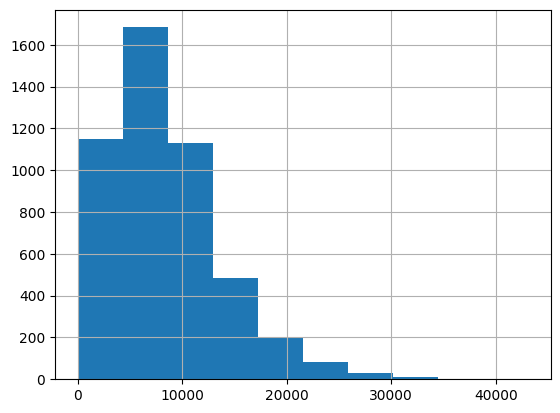

In [176]:
df.steps.hist()

### Time in Heart Rate Zones

Minutes below zone, and in zones 1, 2, and 3.

In [177]:
users_time_in_heart_rate_zones = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "time_in_heart_rate_zones"},
            {"id": user}
        ]},
            {"id": 1, "data.dateTime": 1, "data.value": 1, "_id": 0}
        )
    ))

    users_time_in_heart_rate_zones = pd.concat([users_time_in_heart_rate_zones, user_data], axis=0)

# split data column (json format) into two columns
users_time_in_heart_rate_zones["date"] = users_time_in_heart_rate_zones["data"].apply(lambda d: d["dateTime"])
users_time_in_heart_rate_zones["minutes_in_default_zone_1"] = users_time_in_heart_rate_zones["data"].apply(lambda d: d["value"].get("valuesInZones").get("IN_DEFAULT_ZONE_1"))
users_time_in_heart_rate_zones["minutes_below_default_zone_1"] = users_time_in_heart_rate_zones["data"].apply(lambda d: d["value"].get("valuesInZones").get("BELOW_DEFAULT_ZONE_1"))
users_time_in_heart_rate_zones["minutes_in_default_zone_2"] = users_time_in_heart_rate_zones["data"].apply(lambda d: d["value"].get("valuesInZones").get("IN_DEFAULT_ZONE_2"))
users_time_in_heart_rate_zones["minutes_in_default_zone_3"] = users_time_in_heart_rate_zones["data"].apply(lambda d: d["value"].get("valuesInZones").get("IN_DEFAULT_ZONE_3"))
users_time_in_heart_rate_zones.drop(["data"], inplace=True, axis=1)

# convert timestamp date object and then to datetime64[ns]
users_time_in_heart_rate_zones["date"] = pd.to_datetime(pd.to_datetime(users_time_in_heart_rate_zones["date"], format="%m/%d/%y %H:%M:%S").dt.date, format="%Y/%m/%d")

In [178]:
users_time_in_heart_rate_zones.head(20)

,id,date,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3
0,621e2e8e67b776a24055b564,2021-05-26,85.0,1350.0,0.0,0.0
1,621e2e8e67b776a24055b564,2021-05-30,20.0,1160.0,0.0,0.0
2,621e2e8e67b776a24055b564,2021-06-03,68.0,1368.0,0.0,0.0
3,621e2e8e67b776a24055b564,2021-06-07,61.0,1366.0,0.0,0.0
4,621e2e8e67b776a24055b564,2021-06-11,95.0,1289.0,0.0,0.0
5,621e2e8e67b776a24055b564,2021-06-15,53.0,1377.0,5.0,0.0
6,621e2e8e67b776a24055b564,2021-06-19,116.0,1301.0,0.0,0.0
7,621e2e8e67b776a24055b564,2021-06-23,67.0,1361.0,0.0,0.0
8,621e2e8e67b776a24055b564,2021-06-27,47.0,1386.0,0.0,0.0
9,621e2e8e67b776a24055b564,2021-07-01,42.0,1390.0,2.0,0.0


In [179]:
# merge
df = df.merge(users_time_in_heart_rate_zones, how='outer', on=['id', 'date'])
df.head(20)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,...,sleep_efficiency,sleep_deep_ratio,sleep_wake_ratio,sleep_light_ratio,sleep_rem_ratio,steps,minutes_in_default_zone_1,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,-1.788325,None,2351.59,...,93.0,1.243243,0.987013,0.921642,1.341772,8833.0,83.0,1349.0,0.0,0.0
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,-2.462709,None,2332.08,...,94.0,1.466667,1.142857,0.947566,1.197531,9727.0,56.0,1374.0,4.0,0.0
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,-2.385801,None,2262.30,...,96.0,1.116883,0.858974,1.015038,1.670732,8253.0,85.0,1350.0,0.0,0.0
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,-2.124199,[LIFETIME_DISTANCE],2325.10,...,93.0,1.128205,1.129870,1.191729,1.588235,9015.0,90.0,1282.0,0.0,0.0
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,-2.396873,None,2586.76,...,94.0,0.910256,0.871795,1.211896,1.090909,12949.0,146.0,1274.0,4.0,0.0
5,621e2e8e67b776a24055b564,2021-05-29,34.610929,57.314,89.941,NaN,14.8,-2.638646,"[LIFETIME_FLOORS, DAILY_FLOORS, DAILY_STEPS]",3806.02,...,95.0,0.846154,0.870130,1.110294,1.170455,25526.0,428.0,986.0,2.0,0.0
6,621e2e8e67b776a24055b564,2021-05-30,34.469155,61.900,92.763,NaN,15.2,-1.090828,None,1968.24,...,94.0,0.974026,0.909091,1.120438,1.157303,3796.0,20.0,1160.0,0.0,0.0
7,621e2e8e67b776a24055b564,2021-05-31,34.476865,58.652,109.509,NaN,14.8,-2.577960,None,2300.02,...,96.0,1.025974,1.078947,1.090909,1.311111,9245.0,65.0,1365.0,0.0,0.0
8,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717,NaN,14.4,-2.179900,None,2227.17,...,94.0,1.090909,1.051948,1.137681,1.153846,8422.0,47.0,1369.0,1.0,0.0
9,621e2e8e67b776a24055b564,2021-06-02,34.511263,60.259,111.776,NaN,15.0,-2.090289,None,2262.88,...,96.0,1.423077,1.233766,0.935252,1.186813,8284.0,71.0,1326.0,0.0,0.0


In [180]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'minutes_below_default_zone_1'], keep=False)].shape[0]))

Duplicates based on ID and Date: 136
Duplicates based on ID and Date and Value: 134


<AxesSubplot:>

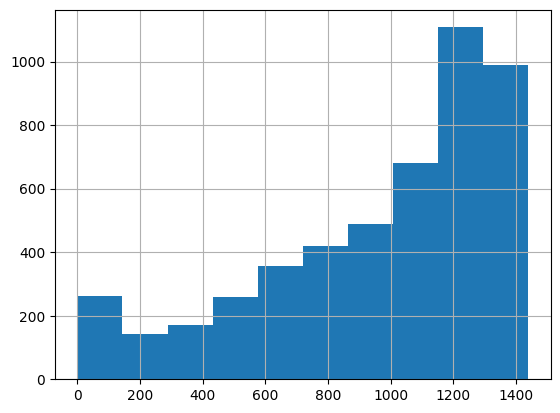

In [181]:
df['minutes_below_default_zone_1'].hist()

<AxesSubplot:>

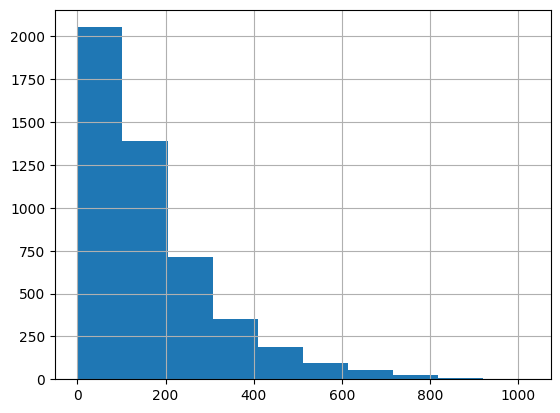

In [182]:
df['minutes_in_default_zone_1'].hist()

<AxesSubplot:>

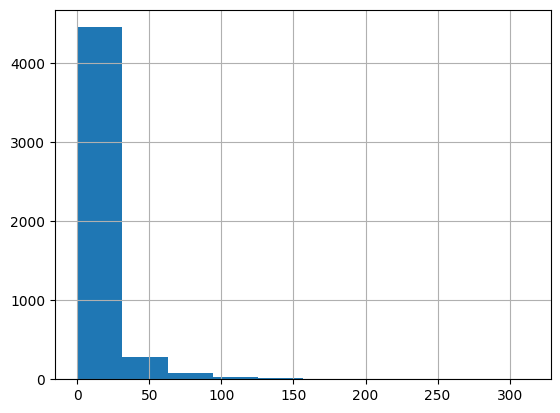

In [183]:
df['minutes_in_default_zone_2'].hist()

<AxesSubplot:>

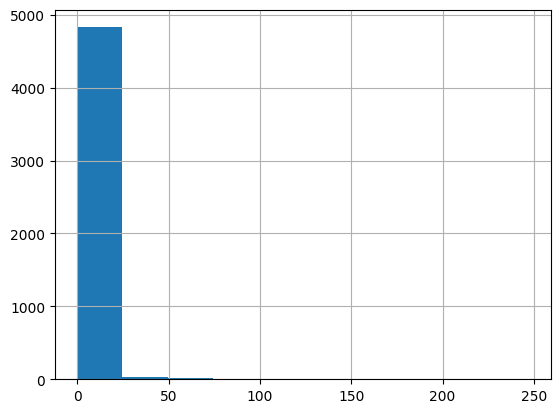

In [184]:
df['minutes_in_default_zone_3'].hist()

### Profile

Demographic Information about the user (N=70).

In [185]:
def get_age(date_of_birth):
    today = date.today()
    return today.year - date_of_birth.year - ((today.month, today.day) < (date_of_birth.month, date_of_birth.day))

In [186]:
users_profiles = pd.DataFrame(columns=["id", "data"])
for user in users:
    user_data = pd.DataFrame(list(
        db.fitbit.find({"$and": [
            {"type": "Profile"},
            {"id": user}
        ]},
            # {"id": 1, "data.date_of_birth": 1, "data.gender": 1, "data.height": 1, "data.weight": 1,  "_id": 0}
            {"id": 1, "data.age": 1, "data.gender": 1, "data.bmi": 1,  "_id": 0}
        )
    ))

    users_profiles = pd.concat([users_profiles, user_data], axis=0)

# users_profiles["age"] = users_profiles["data"].apply(lambda d: d["date_of_birth"])
# users_profiles["age"] = pd.to_datetime(users_profiles["age"], format="%Y/%m/%d")
# users_profiles["age"] = users_profiles["age"].apply(lambda d: get_age(d))
# users_profiles["height"] = users_profiles["data"].apply(lambda d: d["height"])
# users_profiles["weight"] = users_profiles["data"].apply(lambda d: d["weight"])
# users_profiles["gender"] = users_profiles["data"].apply(lambda d: d["gender"])


users_profiles["age"] = users_profiles["data"].apply(lambda d: d["age"] if "age" in d else np.NaN)
users_profiles["gender"] = users_profiles["data"].apply(lambda d: d["gender"] if "gender" in d else np.NaN)
users_profiles["bmi"] = users_profiles["data"].apply(lambda d: d["bmi"] if "bmi" in d else np.NaN)

users_profiles.drop(['data'], axis=1, inplace=True)
users_profiles.head(70)

,id,age,gender,bmi
0,621e2e8e67b776a24055b564,<30,MALE,<19
0,621e2eaf67b776a2406b14ac,>=30,FEMALE,<19
0,621e2ed667b776a24085d8d1,<30,FEMALE,23.0
0,621e2ef567b776a24099f889,<30,MALE,28.0
0,621e2efa67b776a2409dd1c3,<30,FEMALE,21.0
...,...,...,...,...
0,621e36c267b776a240ba2756,<30,MALE,20.0
0,621e36dd67b776a240ce9a45,>=30,MALE,24.0
0,621e36f967b776a240e5e7c9,<30,FEMALE,>=25
0,621e375367b776a24021e950,<30,MALE,28.0


In [187]:
# merge
df = df.merge(users_profiles, how='left', on=['id'])

## Saving to pickle file

In [188]:
df.to_pickle('daily_fitbit_df_unprocessed.pkl')

In [189]:
df = pd.read_pickle('daily_fitbit_df_unprocessed.pkl')

## Integrating SEMA Data

The SEMA ecological ecological momentary assessment surveys include data about the users' daily step goals (maximum once per day) as well as emotions and locations (maximum three times a day)

### Integrating step goals

This field includes the user's daily step goal range (N=1921).

In [190]:
# user goals in SEMA
SEMA_GOALS_TO_MIN = {
    "2000": 0,
    "4999": 2000,
    "7999": 5000,
    "9999": 8000,
    "14999": 10000,
    "19999": 15000,
    "24999": 20000,
    "25000": 25000,
    "NO_GOAL": 0
}

SEMA_GOALS_TO_MAX = {
    "2000": 2000,
    "4999": 5000,
    "7999": 8000,
    "9999": 10000,
    "14999": 15000,
    "19999": 20000,
    "24999": 25000,
    "25000": 30000,
    "NO_GOAL": 0
}

SEMA_LABELS = {
    "2000": "Less than 2000",
    "4999": "2000-4999",
    "7999": "5000-7999",
    "9999": "8000-9999",
    "14999": "10000-14999",
    "19999": "15000-19999",
    "24999": "20000-24999",
    "25000": "More than 25000",
    "NO_GOAL": "No Goal",
    np.nan: "No Goal",
    None: "No Goal"
}

In [192]:
if not os.path.exists("users_step_goals_daily.pkl"):
    # Get user self-reported goals from SEMA
    sema_goals = pd.DataFrame(columns=["_id", "user_id", "data"])
    for user in users:
        user_data = pd.DataFrame(list(
                        db.sema.find({ "$and": [
                            { "data.STEPS": { "$ne": "<no-response>" } },
                            {"user_id": user}
                        ] },
                            {"data.STEPS": 1, "id": 1, "user_id": 1, "data.STARTED_TS": 1}
                        )
                    ))

        sema_goals = pd.concat([sema_goals, user_data], axis=0)

    # split data column (json format) into two columns
    sema_goals["timestamp"] = sema_goals["data"].apply(lambda d: d["STARTED_TS"])
    sema_goals["step_goal"] = sema_goals["data"].apply(lambda d: d["STEPS"])
    sema_goals.drop(["data", "_id"], inplace=True, axis=1)

    # convert timestamp to day format
    sema_goals["date"] = pd.to_datetime(sema_goals["timestamp"], infer_datetime_format=True).dt.date
    sema_goals["date"] = pd.to_datetime(sema_goals["date"], infer_datetime_format=True) # convert from object to datetime
    sema_goals.drop(["timestamp"], inplace=True, axis=1)

    # add min goal and max goal columns
    sema_goals['min_goal'] = sema_goals.step_goal.apply(lambda s: SEMA_GOALS_TO_MIN.get(s))
    sema_goals['max_goal'] = sema_goals.step_goal.apply(lambda s: SEMA_GOALS_TO_MAX.get(s))

    # add goal labels
    sema_goals['step_goal_label'] = sema_goals['step_goal'].apply(lambda v: SEMA_LABELS[v])
    sema_goals[['date', 'user_id', 'step_goal', 'min_goal', 'max_goal', 'step_goal_label']].to_pickle('users_step_goals_daily.pkl')

users_step_goals = pd.read_pickle('users_step_goals_daily.pkl')
users_step_goals['id'] = users_step_goals.user_id.copy()
users_step_goals.drop(['user_id'], axis=1, inplace=True)

In [193]:
users_step_goals.head(10)

,date,step_goal,min_goal,max_goal,step_goal_label,id
0,2021-07-18,7999,5000.0,8000.0,5000-7999,621e2e8e67b776a24055b564
1,2021-06-27,7999,5000.0,8000.0,5000-7999,621e2e8e67b776a24055b564
2,2021-07-23,14999,10000.0,15000.0,10000-14999,621e2e8e67b776a24055b564
3,2021-06-03,9999,8000.0,10000.0,8000-9999,621e2e8e67b776a24055b564
4,2021-07-14,9999,8000.0,10000.0,8000-9999,621e2e8e67b776a24055b564
5,2021-06-18,9999,8000.0,10000.0,8000-9999,621e2e8e67b776a24055b564
6,2021-06-20,7999,5000.0,8000.0,5000-7999,621e2e8e67b776a24055b564
7,2021-07-24,9999,8000.0,10000.0,8000-9999,621e2e8e67b776a24055b564
8,2021-06-13,4999,2000.0,5000.0,2000-4999,621e2e8e67b776a24055b564
9,2021-05-25,14999,10000.0,15000.0,10000-14999,621e2e8e67b776a24055b564


In [194]:
# merge
df = df.merge(users_step_goals, how='outer', on=['id', 'date'])
df.head(10)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,...,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,age,gender,bmi,step_goal,min_goal,max_goal,step_goal_label
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,-1.788325,None,2351.59,...,1349.0,0.0,0.0,<30,MALE,<19,NaN,NaN,NaN,NaN
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,-2.462709,None,2332.08,...,1374.0,4.0,0.0,<30,MALE,<19,14999,10000.0,15000.0,10000-14999
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,-2.385801,None,2262.30,...,1350.0,0.0,0.0,<30,MALE,<19,NaN,NaN,NaN,NaN
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,-2.124199,[LIFETIME_DISTANCE],2325.10,...,1282.0,0.0,0.0,<30,MALE,<19,14999,10000.0,15000.0,10000-14999
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,-2.396873,None,2586.76,...,1274.0,4.0,0.0,<30,MALE,<19,NaN,NaN,NaN,NaN
5,621e2e8e67b776a24055b564,2021-05-29,34.610929,57.314,89.941,NaN,14.8,-2.638646,"[LIFETIME_FLOORS, DAILY_FLOORS, DAILY_STEPS]",3806.02,...,986.0,2.0,0.0,<30,MALE,<19,NaN,NaN,NaN,NaN
6,621e2e8e67b776a24055b564,2021-05-30,34.469155,61.900,92.763,NaN,15.2,-1.090828,None,1968.24,...,1160.0,0.0,0.0,<30,MALE,<19,4999,2000.0,5000.0,2000-4999
7,621e2e8e67b776a24055b564,2021-05-31,34.476865,58.652,109.509,NaN,14.8,-2.577960,None,2300.02,...,1365.0,0.0,0.0,<30,MALE,<19,9999,8000.0,10000.0,8000-9999
8,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717,NaN,14.4,-2.179900,None,2227.17,...,1369.0,1.0,0.0,<30,MALE,<19,9999,8000.0,10000.0,8000-9999
9,621e2e8e67b776a24055b564,2021-06-02,34.511263,60.259,111.776,NaN,15.0,-2.090289,None,2262.88,...,1326.0,0.0,0.0,<30,MALE,<19,9999,8000.0,10000.0,8000-9999


In [195]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'step_goal_label'], keep=False)].shape[0]))

Duplicates based on ID and Date: 148
Duplicates based on ID and Date and Value: 142


In [196]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
no_dups = df.astype(str).drop_duplicates()
no_dups[no_dups.astype(str).duplicated(keep = False, subset=['id','date'])]

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,...,minutes_below_default_zone_1,minutes_in_default_zone_2,minutes_in_default_zone_3,age,gender,bmi,step_goal,min_goal,max_goal,step_goal_label
1751,621e301e67b776a240608a72,2021-08-28,31.0584031414,nan,nan,nan,nan,-2.3384952674311927,None,2810.01,...,154.0,65.0,0.0,<30,FEMALE,19.0,nan,nan,nan,nan
1752,621e301e67b776a240608a72,2021-08-28,31.0584031414,nan,nan,nan,nan,-2.3384952674311927,None,2810.01,...,219.0,100.0,0.0,<30,FEMALE,19.0,nan,nan,nan,nan
7426,621e362467b776a2404ad513,2021-04-10,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,2000,0.0,2000.0,Less than 2000
7427,621e362467b776a2404ad513,2021-04-10,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,19999,15000.0,20000.0,15000-19999
7429,621e362467b776a2404ad513,2021-04-22,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,14999,10000.0,15000.0,10000-14999
7430,621e362467b776a2404ad513,2021-04-22,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,4999,2000.0,5000.0,2000-4999
7434,621e362467b776a2404ad513,2021-04-09,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,9999,8000.0,10000.0,8000-9999
7435,621e362467b776a2404ad513,2021-04-09,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,7999,5000.0,8000.0,5000-7999


In [197]:
print("Size before duplicate elimination: {}".format(df.shape[0]))
df = df.groupby(["id", "date"]).first()
df.reset_index(drop=False, inplace=True)
print("Size after duplicate elimination: {}".format(df.shape[0]))

Size before duplicate elimination: 7474
Size after duplicate elimination: 7400


### Integrating Εmotions & Location

In [198]:
# read data
if not os.path.exists('sema_mood_place.pkl'):
    # Get user self-reported goals from SEMA
    users = db.sema.distinct('user_id')

    sema_mood = pd.DataFrame(columns=["_id", "user_id", "data"])
    for user in users:
        user_data = pd.DataFrame(list(
                        db.sema.find({
                            "$or": [
                                {
                                    "$and": [
                                        { "data.MOOD": { "$ne": "<no-response>" } },
                                        {"data.MOOD": { "$ne": None }},
                                        {"user_id": user}
                                    ]
                                },
                                {
                                    "$and": [
                                        { "data.PLACE": { "$ne": "<no-response>" } },
                                        {"data.PLACE": { "$ne": None }},
                                        {"user_id": user}
                                    ]
                                }
                            ]
                        },
                            {"data.MOOD": 1, "data.PLACE": 1, "id": 1, "_id": 0, "user_id": 1, "data.STARTED_TS": 1}
                        )
                    ))

        sema_mood = pd.concat([sema_mood, user_data], axis=0)

sema_mood["date"] = pd.to_datetime(pd.to_datetime(sema_mood["data"].apply(lambda d: d["STARTED_TS"]), infer_datetime_format=True).dt.date, infer_datetime_format=True)
sema_mood["time"] = pd.to_datetime(sema_mood["data"].apply(lambda d: d["STARTED_TS"]), infer_datetime_format=True).dt.time
sema_mood["data.MOOD"] = sema_mood["data"].apply(lambda d: d["MOOD"])
sema_mood["data.PLACE"] = sema_mood["data"].apply(lambda d: d["PLACE"])
sema_mood.drop(["_id", "data"], axis=1, inplace=True)
sema_mood.to_pickle('sema_mood_place.pkl')

In [199]:
infile = open('sema_mood_place.pkl','rb')
sema = pickle.load(infile)
infile.close()

sema.head() # year-month-day e.g. 2021-05-24

,user_id,date,time,data.MOOD,data.PLACE
0,621e2e8e67b776a24055b564,2021-06-10,16:38:00,NEUTRAL,WORK/SCHOOL
1,621e2e8e67b776a24055b564,2021-06-13,14:35:00,NEUTRAL,HOME
2,621e2e8e67b776a24055b564,2021-07-24,15:22:00,HAPPY,OUTDOORS
3,621e2e8e67b776a24055b564,2021-06-01,10:15:00,HAPPY,OUTDOORS
4,621e2e8e67b776a24055b564,2021-06-21,18:32:00,TIRED,OUTDOORS


In [200]:
# process dateTime to date
# sema['date'] = pd.to_datetime(sema['Dates'])
# sema.drop(['data.CREATED_TS', 'Dates'], axis=1, inplace=True)

# replace not common moods
sema['data.MOOD'] = sema['data.MOOD'].apply(lambda mood: 'SAD' if mood == 'SADNESS' else ('HAPPY' if mood == 'JOY' else mood))
sema = sema[(sema['data.MOOD'] != 'FEAR') & (sema['data.MOOD'] != 'SURPRISE') & (sema['data.MOOD'] != 'ANGER') & (sema['data.MOOD'] != '<no-response>')]
print(sema['data.MOOD'].value_counts())
print(sema['data.PLACE'].value_counts())
# drop unessecary columns
sema.drop(['time'], axis=1, inplace=True)

sema.head()

RESTED/RELAXED    1179
TIRED             1126
NEUTRAL            822
HAPPY              790
TENSE/ANXIOUS      620
ALERT              345
SAD                149
Name: data.MOOD, dtype: int64
HOME             2960
WORK/SCHOOL       869
OUTDOORS          381
HOME_OFFICE       309
TRANSIT           224
ENTERTAINMENT     209
OTHER              60
GYM                18
Name: data.PLACE, dtype: int64


,user_id,date,data.MOOD,data.PLACE
0,621e2e8e67b776a24055b564,2021-06-10,NEUTRAL,WORK/SCHOOL
1,621e2e8e67b776a24055b564,2021-06-13,NEUTRAL,HOME
2,621e2e8e67b776a24055b564,2021-07-24,HAPPY,OUTDOORS
3,621e2e8e67b776a24055b564,2021-06-01,HAPPY,OUTDOORS
4,621e2e8e67b776a24055b564,2021-06-21,TIRED,OUTDOORS


In [201]:
sema_moods = pd.get_dummies(sema['data.MOOD'])
sema_places = pd.get_dummies(sema['data.PLACE'])
print(sema_moods.head())
print(sema_places.head())

   ALERT  HAPPY  NEUTRAL  RESTED/RELAXED  SAD  TENSE/ANXIOUS  TIRED
0      0      0        1               0    0              0      0
1      0      0        1               0    0              0      0
2      0      1        0               0    0              0      0
3      0      1        0               0    0              0      0
4      0      0        0               0    0              0      1
   ENTERTAINMENT  GYM  HOME  HOME_OFFICE  OTHER  OUTDOORS  TRANSIT  \
0              0    0     0            0      0         0        0   
1              0    0     1            0      0         0        0   
2              0    0     0            0      0         1        0   
3              0    0     0            0      0         1        0   
4              0    0     0            0      0         1        0   

   WORK/SCHOOL  
0            1  
1            0  
2            0  
3            0  
4            0  


In [202]:
# combine one-hot encoding with actual df
sema = pd.concat([sema, sema_moods, sema_places], axis=1)
sema.drop(['data.MOOD', 'data.PLACE'], axis=1, inplace=True)
sema.head(10)

,user_id,date,ALERT,HAPPY,NEUTRAL,RESTED/RELAXED,SAD,TENSE/ANXIOUS,TIRED,ENTERTAINMENT,GYM,HOME,HOME_OFFICE,OTHER,OUTDOORS,TRANSIT,WORK/SCHOOL
0,621e2e8e67b776a24055b564,2021-06-10,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,621e2e8e67b776a24055b564,2021-06-13,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,621e2e8e67b776a24055b564,2021-07-24,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,621e2e8e67b776a24055b564,2021-06-01,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,621e2e8e67b776a24055b564,2021-06-21,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
5,621e2e8e67b776a24055b564,2021-05-27,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
6,621e2e8e67b776a24055b564,2021-06-15,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
7,621e2e8e67b776a24055b564,2021-07-22,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
8,621e2e8e67b776a24055b564,2021-07-18,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
9,621e2e8e67b776a24055b564,2021-07-11,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [203]:
sema_grouped = sema.groupby(['date', 'user_id']).max()
sema_grouped.reset_index(drop=False, inplace=True)
sema_grouped['id'] = sema_grouped['user_id'].copy()
sema_grouped.drop(['user_id'], axis=1, inplace=True)
sema_grouped.reset_index(drop=True, inplace=True)
sema_grouped.id = sema_grouped.id.swifter.apply(lambda id: ObjectId(id))
sema_grouped.head()

Pandas Apply:   0%|          | 0/2290 [00:00<?, ?it/s]

,date,ALERT,HAPPY,NEUTRAL,RESTED/RELAXED,SAD,TENSE/ANXIOUS,TIRED,ENTERTAINMENT,GYM,HOME,HOME_OFFICE,OTHER,OUTDOORS,TRANSIT,WORK/SCHOOL,id
0,2021-04-22,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,621e362467b776a2404ad513
1,2021-04-23,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,621e362467b776a2404ad513
2,2021-04-24,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,621e362467b776a2404ad513
3,2021-04-25,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,621e362467b776a2404ad513
4,2021-04-26,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,621e362467b776a2404ad513


(array([18748., 18779., 18809., 18840., 18871., 18901., 18932., 18962.,
        18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

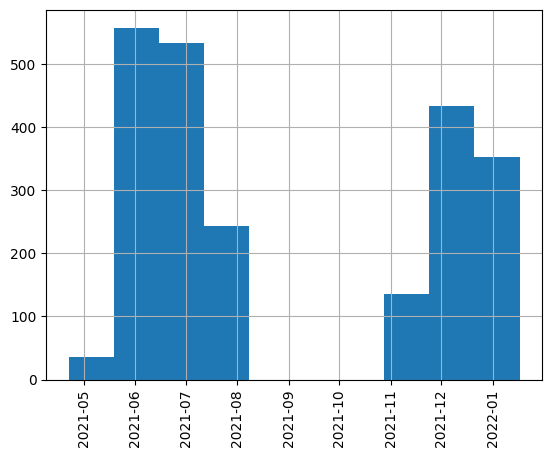

In [204]:
sema_grouped.date.hist()
plt.xticks(rotation=90)

In [205]:
# merge
df = df.merge(sema_grouped, how='outer', on=['id', 'date'])
df.head(10)

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,daily_temperature_variation,badgeType,calories,...,TENSE/ANXIOUS,TIRED,ENTERTAINMENT,GYM,HOME,HOME_OFFICE,OTHER,OUTDOORS,TRANSIT,WORK/SCHOOL
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,-1.788325,None,2351.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,621e2e8e67b776a24055b564,2021-05-25,33.794544,57.681,94.303,NaN,15.8,-2.462709,None,2332.08,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,621e2e8e67b776a24055b564,2021-05-26,34.611011,57.481,119.212,NaN,14.6,-2.385801,None,2262.30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,621e2e8e67b776a24055b564,2021-05-27,34.408304,57.493,111.709,NaN,14.8,-2.124199,[LIFETIME_DISTANCE],2325.10,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,621e2e8e67b776a24055b564,2021-05-28,34.178922,56.750,103.034,NaN,15.2,-2.396873,None,2586.76,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,621e2e8e67b776a24055b564,2021-05-29,34.610929,57.314,89.941,NaN,14.8,-2.638646,"[LIFETIME_FLOORS, DAILY_FLOORS, DAILY_STEPS]",3806.02,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6,621e2e8e67b776a24055b564,2021-05-30,34.469155,61.900,92.763,NaN,15.2,-1.090828,None,1968.24,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7,621e2e8e67b776a24055b564,2021-05-31,34.476865,58.652,109.509,NaN,14.8,-2.577960,None,2300.02,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8,621e2e8e67b776a24055b564,2021-06-01,34.284452,56.507,117.717,NaN,14.4,-2.179900,None,2227.17,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
9,621e2e8e67b776a24055b564,2021-06-02,34.511263,60.259,111.776,NaN,15.0,-2.090289,None,2262.88,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [206]:
# checking for duplicates; if the two values are identical it means that all duplicates (in terms of date and ID) have also equal values.
print("Duplicates based on ID and Date: {}".format(df[df.duplicated(subset=['id','date'], keep=False)].shape[0]))
print("Duplicates based on ID and Date and Value: {}".format(df[df.duplicated(subset=['id','date', 'full_sleep_breathing_rate'], keep=False)].shape[0]))

Duplicates based on ID and Date: 0
Duplicates based on ID and Date and Value: 0


In [207]:
df.to_pickle('daily_fitbit_sema_df_unprocessed.pkl')

In [209]:
df = pd.read_pickle('daily_fitbit_sema_df_unprocessed.pkl')

In [210]:
df.shape[0]

7410

In [211]:
df.to_csv('daily_fitbit_sema_df_unprocessed.csv')